# Double Jet

With various grid sizes

In [1]:
from gpuocean.SWEsimulators import ModelErrorKL, CDKLM16
from gpuocean.utils import Common, IPythonMagic

from importlib import reload

import numpy as np
import copy
import pycuda.driver as cuda
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

plt.rcParams["image.origin"] = "lower"


In [2]:
%cuda_context_handler gpu_ctx

In [3]:
gpu_stream = cuda.Stream()

In [4]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))

Get initial arguments from class

In [5]:
from gpuocean.utils import DoubleJetCase

In [6]:
doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=512, nx=1024)
doubleJetCase_args, doubleJetCase_init, _ = doubleJetCase.getInitConditions()

## Truth

In [7]:
from gpuocean.utils import Observation, DrifterPlotHelper

In [8]:
truth_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetTruth/2023-11-02T09_33_29"

true_trajectories = Observation.Observation(domain_size_x=doubleJetCase_args["nx"]*doubleJetCase_args["dx"],
                                            domain_size_y=doubleJetCase_args["ny"]*doubleJetCase_args["dy"], 
                                            nx=doubleJetCase_args["nx"], ny=doubleJetCase_args["ny"])

true_trajectories.read_pickle(os.path.join(truth_path, "truth_trajectories.pickle"))

In [9]:
true_trajectories.get_num_drifters()

100

## Ensemble drifter

In [11]:
slda_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetSLDA/2023-11-10T11_44_24"

slda_drifter_path = os.path.join(slda_path, "sldrifters_60")

slda_trajectories = []
for f in os.listdir(slda_drifter_path):
    if f.startswith("sl"):
        trajectory = Observation.Observation(domain_size_x=doubleJetCase_args["nx"]*doubleJetCase_args["dx"],
                                                domain_size_y=doubleJetCase_args["ny"]*doubleJetCase_args["dy"], 
                                                nx=doubleJetCase_args["nx"], ny=doubleJetCase_args["ny"])

        trajectory.read_pickle(os.path.join(slda_drifter_path,f))
        
        slda_trajectories.append(trajectory)



slda_trajectories2 = []
for f in os.listdir(slda_drifter_path):
    if f.startswith("ml"):
        trajectory = Observation.Observation(domain_size_x=doubleJetCase_args["nx"]*doubleJetCase_args["dx"],
                                                domain_size_y=doubleJetCase_args["ny"]*doubleJetCase_args["dy"], 
                                                nx=doubleJetCase_args["nx"], ny=doubleJetCase_args["ny"])

        trajectory.read_pickle(os.path.join(slda_drifter_path,f))
        
        slda_trajectories2.append(trajectory)

In [12]:
mlda_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetMLDA/2023-11-09T18_07_14"
mlda_drifter_path = os.path.join(mlda_path, "mldrifters_60")

# mlda_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetMLDA/2023-11-08T15_45_28"
# mlda_drifter_path = os.path.join(mlda_path, "mldrifters")

mlda_trajectories = []
for f in os.listdir(mlda_drifter_path):
    trajectory = Observation.Observation(domain_size_x=doubleJetCase_args["nx"]*doubleJetCase_args["dx"],
                                            domain_size_y=doubleJetCase_args["ny"]*doubleJetCase_args["dy"], 
                                            nx=doubleJetCase_args["nx"], ny=doubleJetCase_args["ny"])

    trajectory.read_pickle(os.path.join(mlda_drifter_path,f))
    
    mlda_trajectories.append(trajectory)

## Drifters

/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


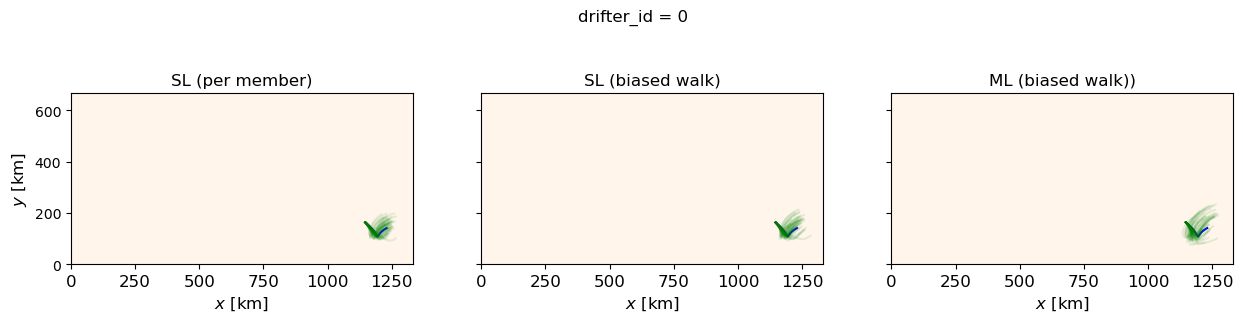

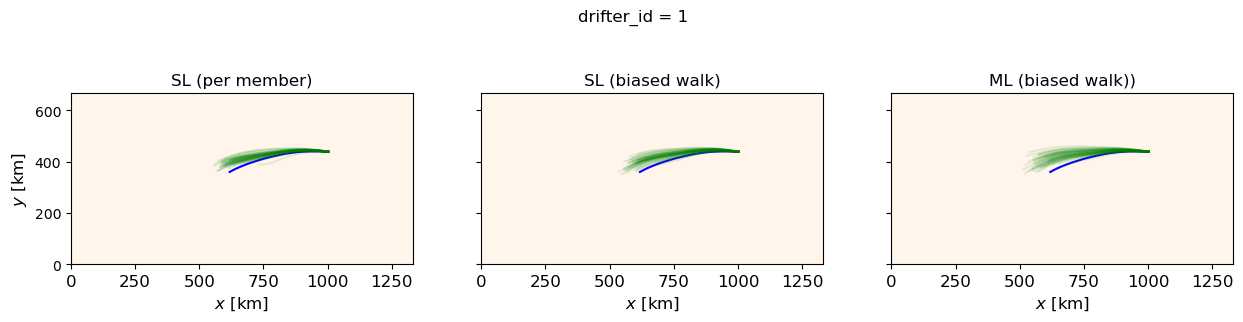

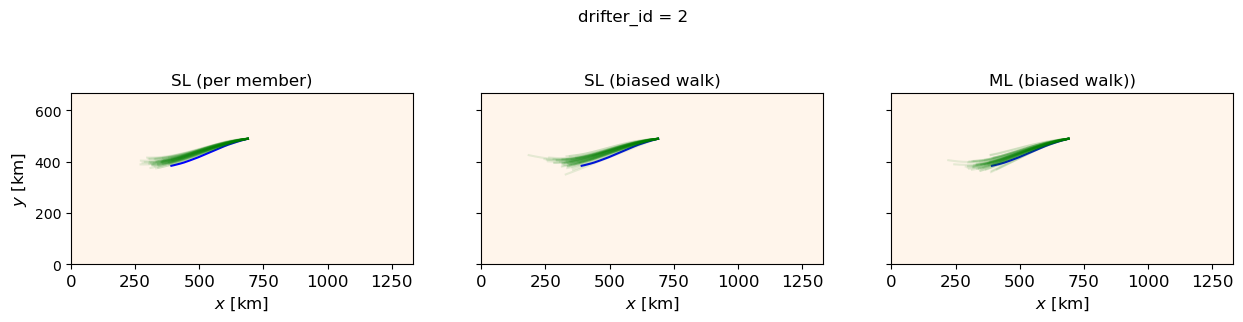

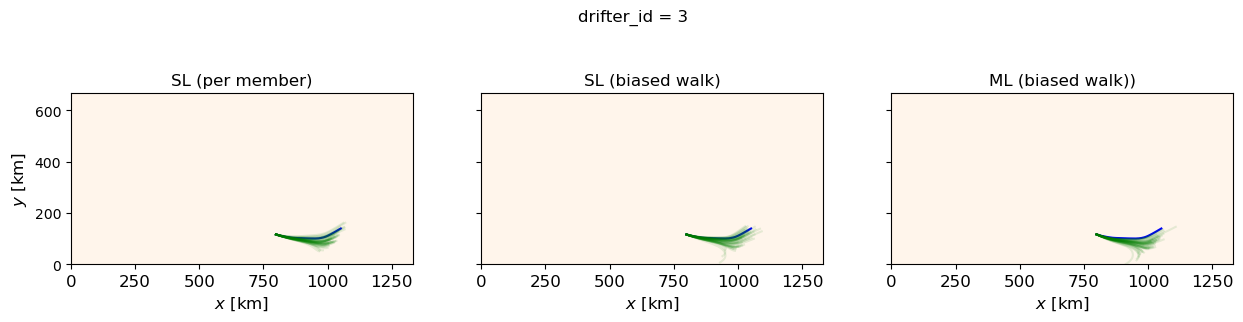

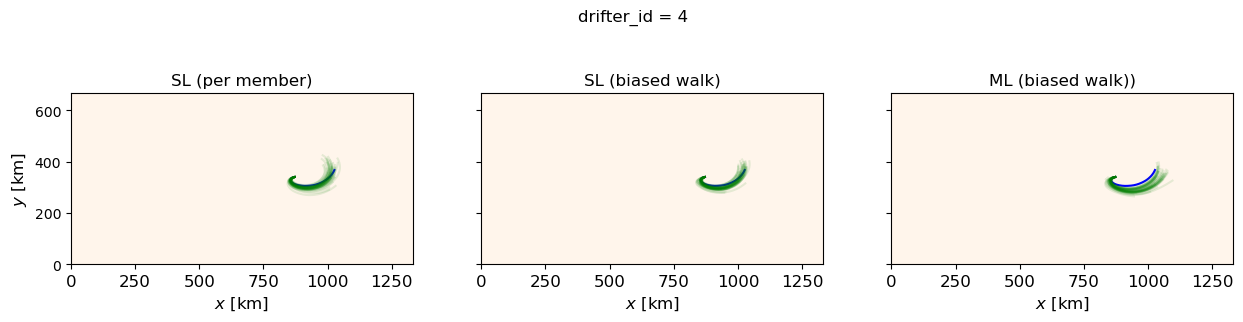

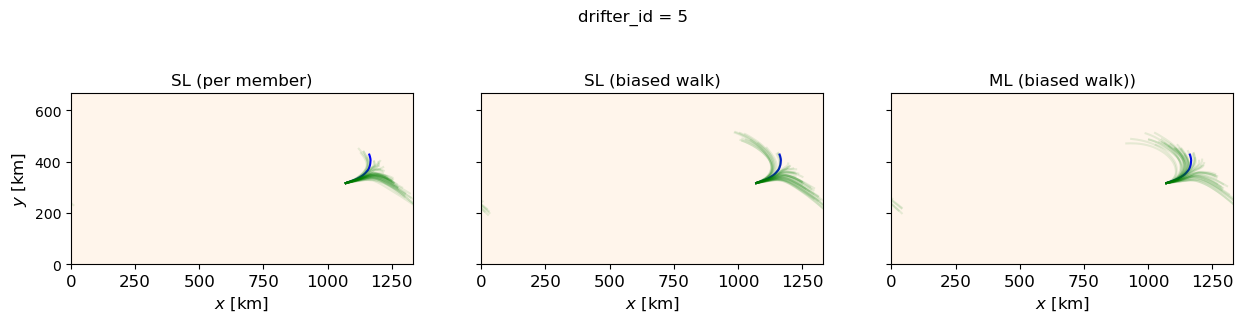

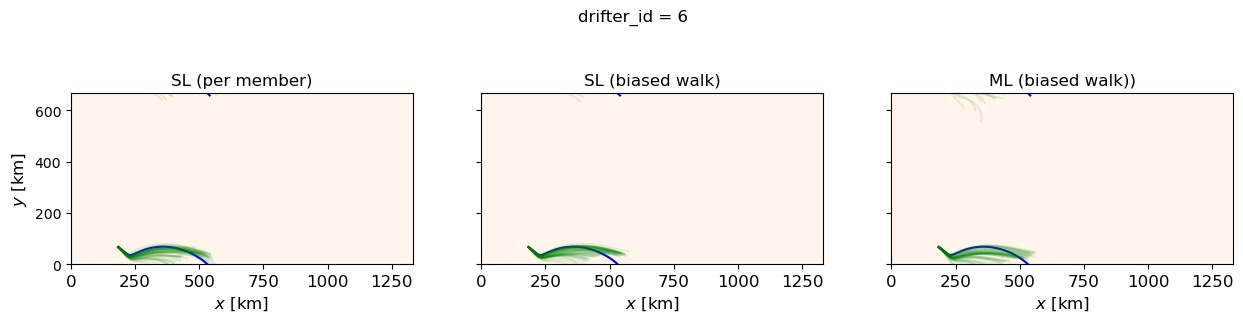

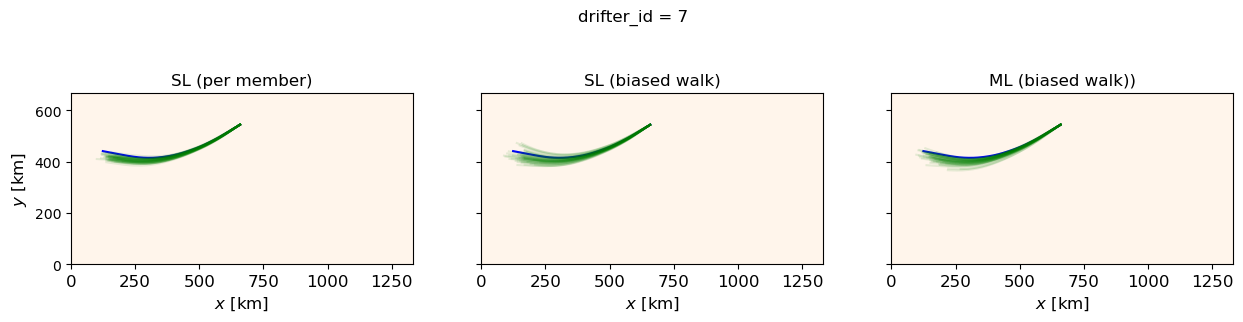

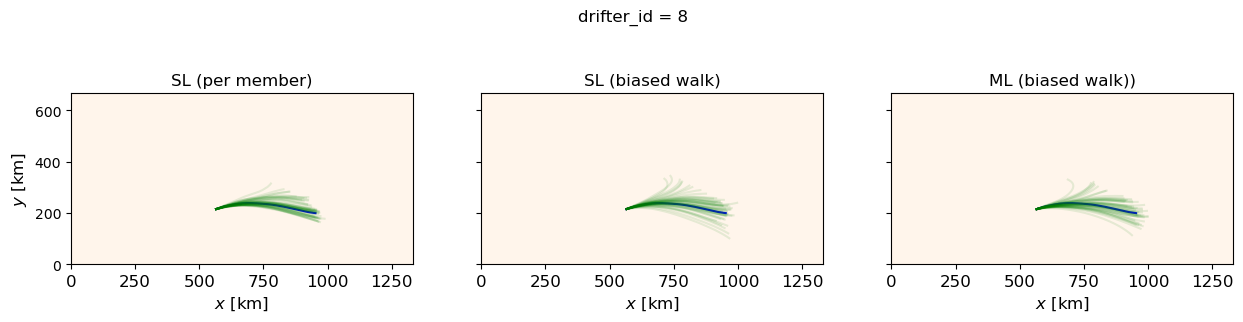

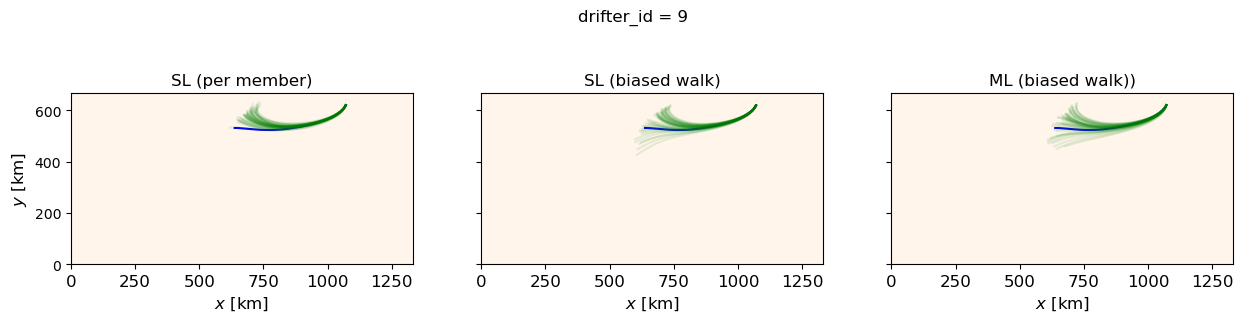

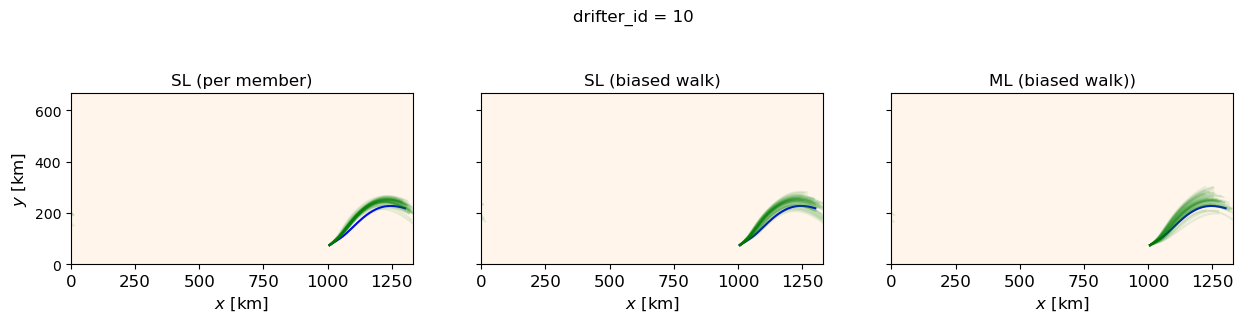

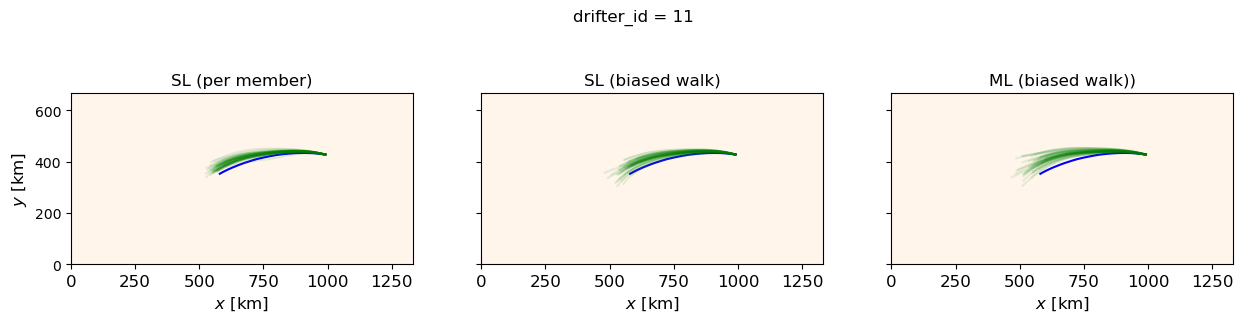

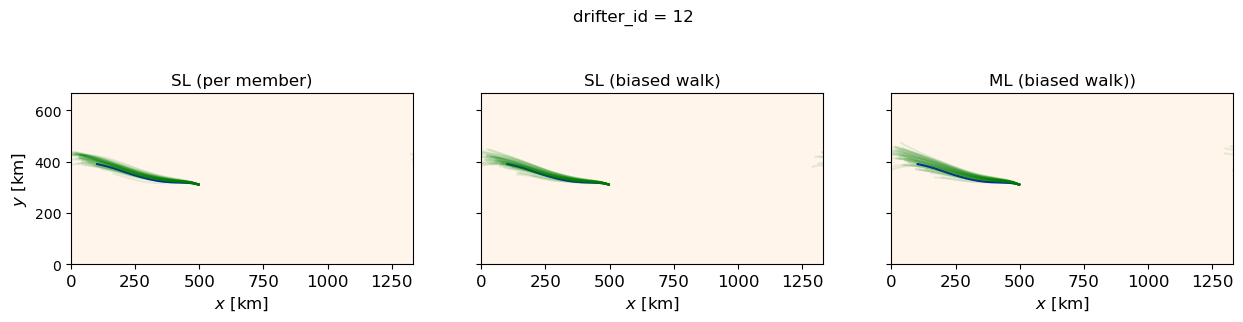

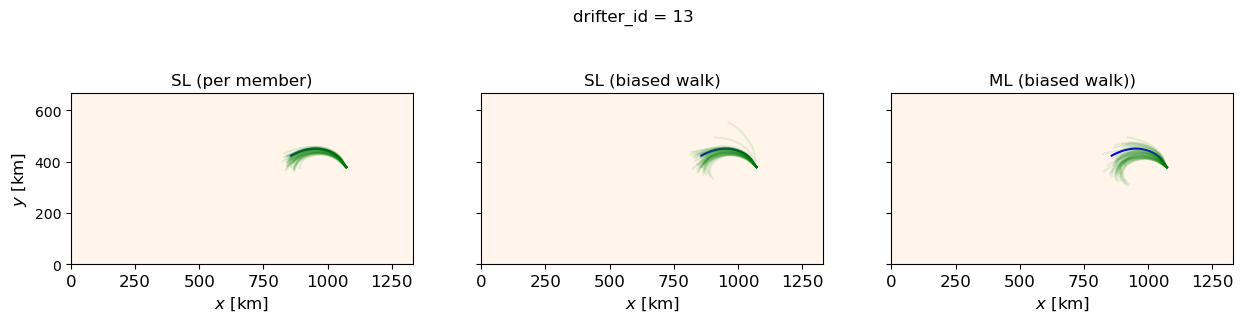

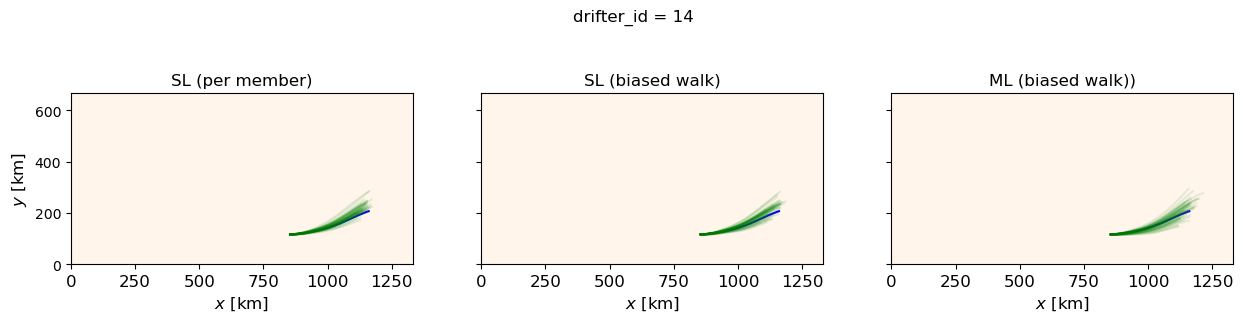

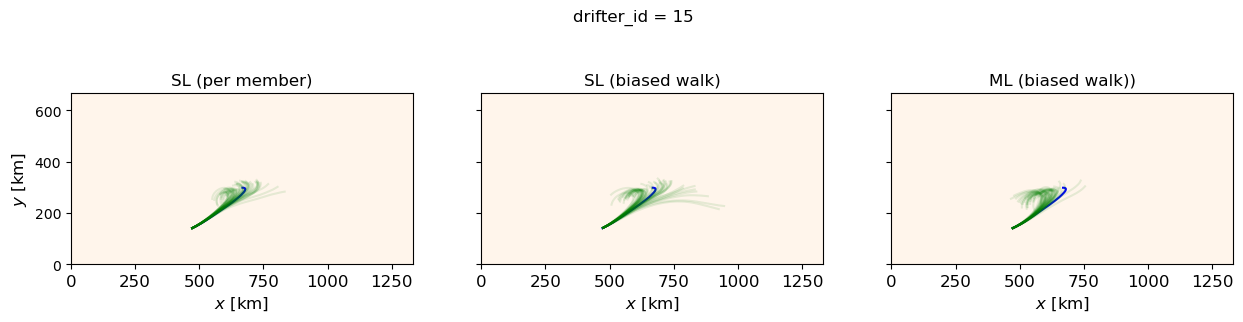

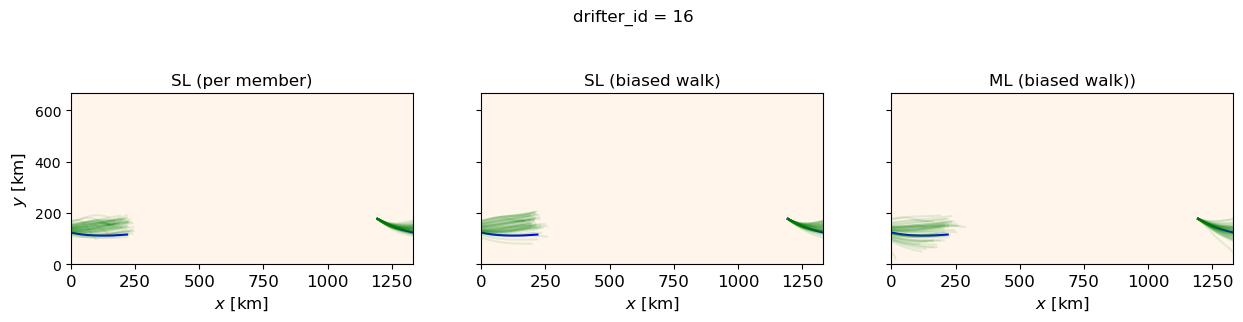

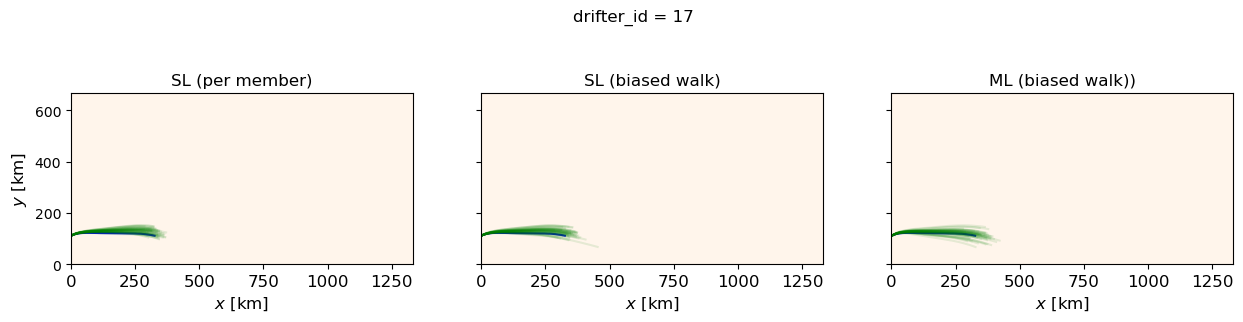

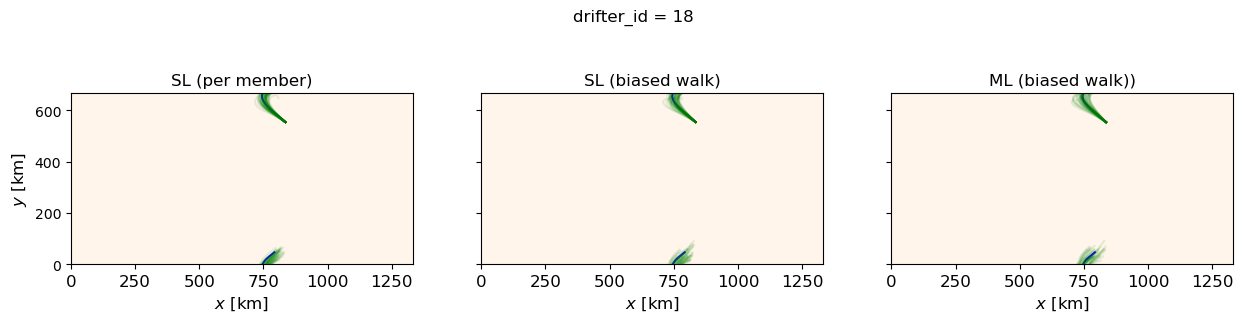

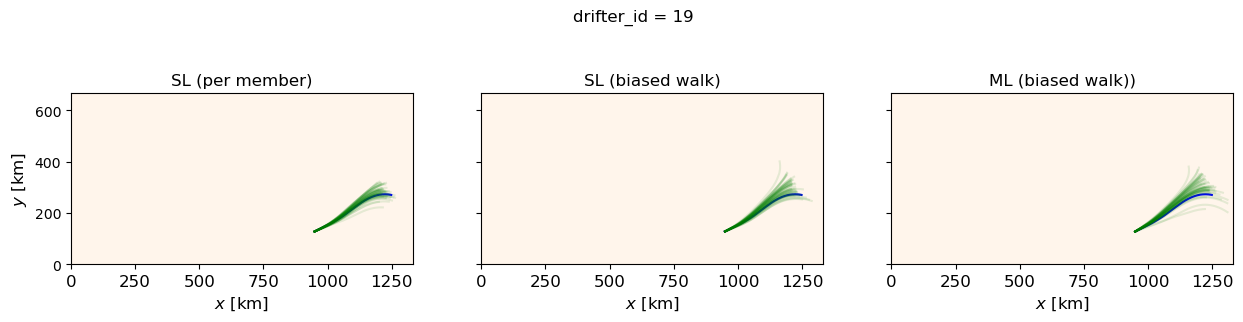

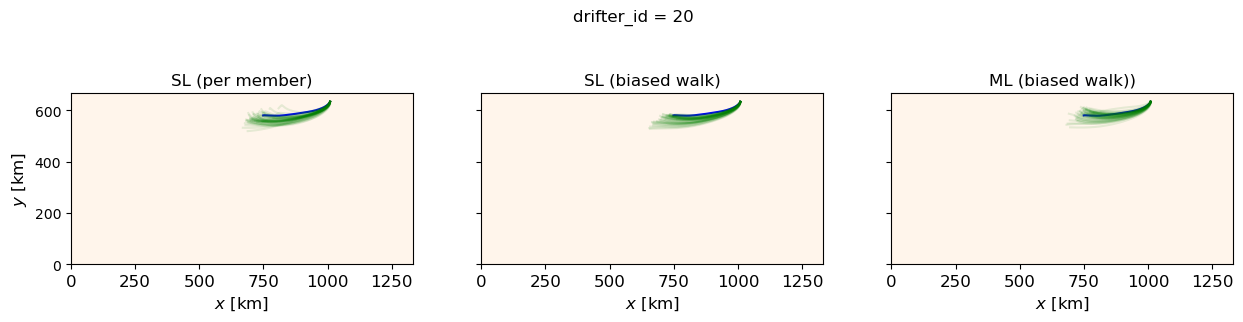

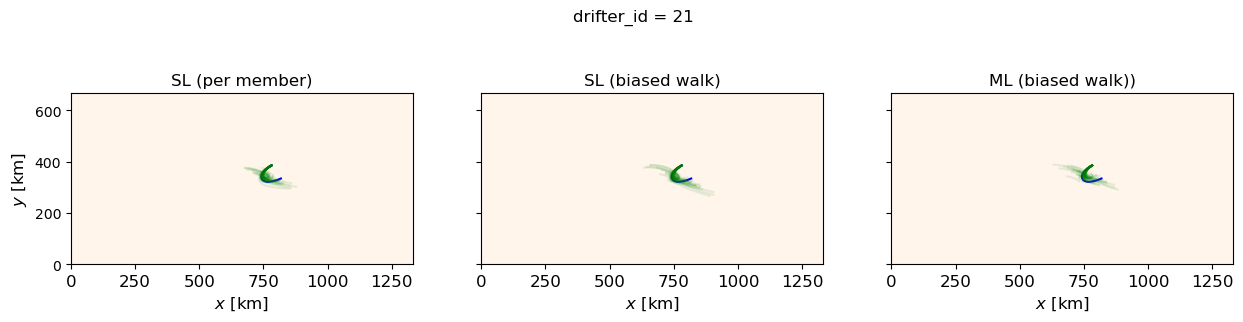

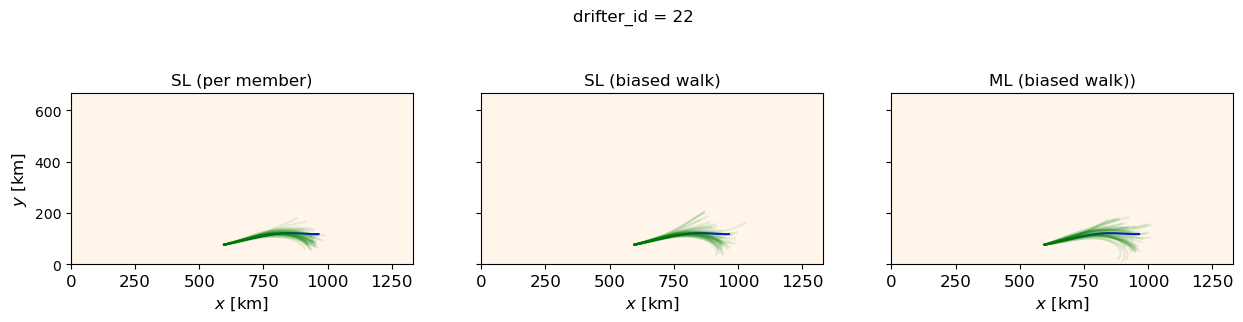

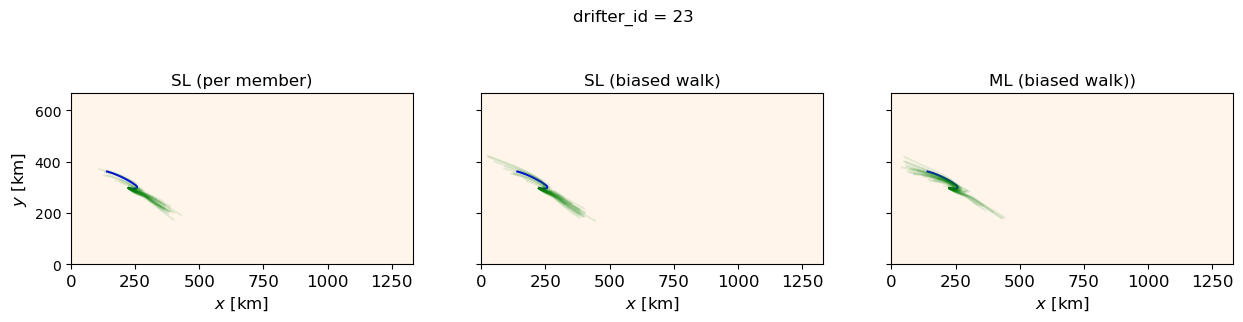

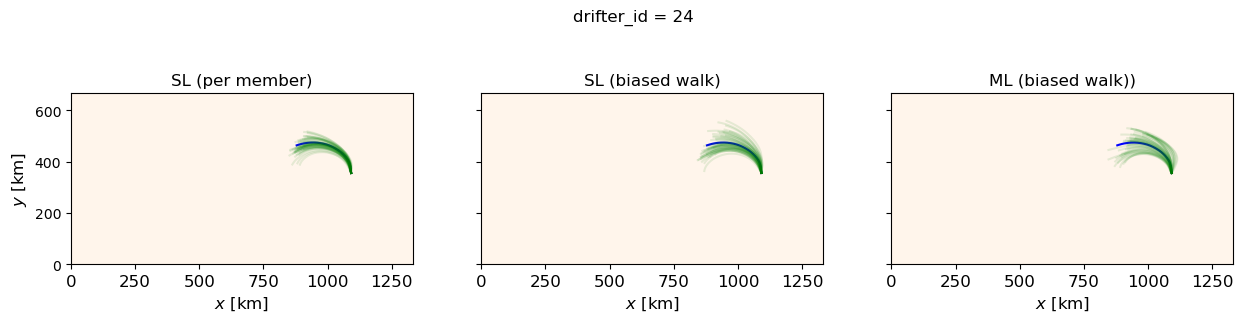

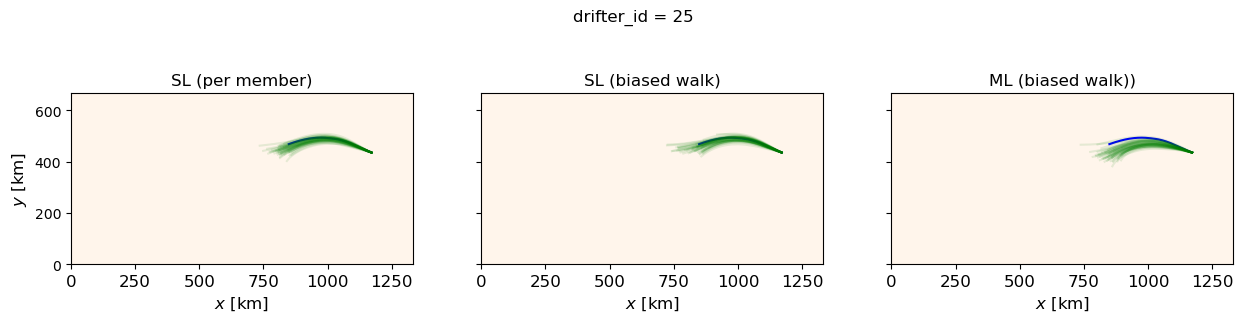

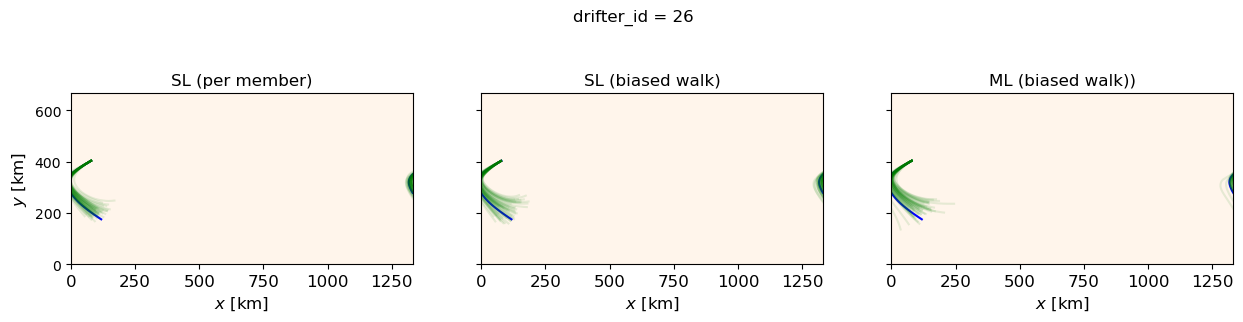

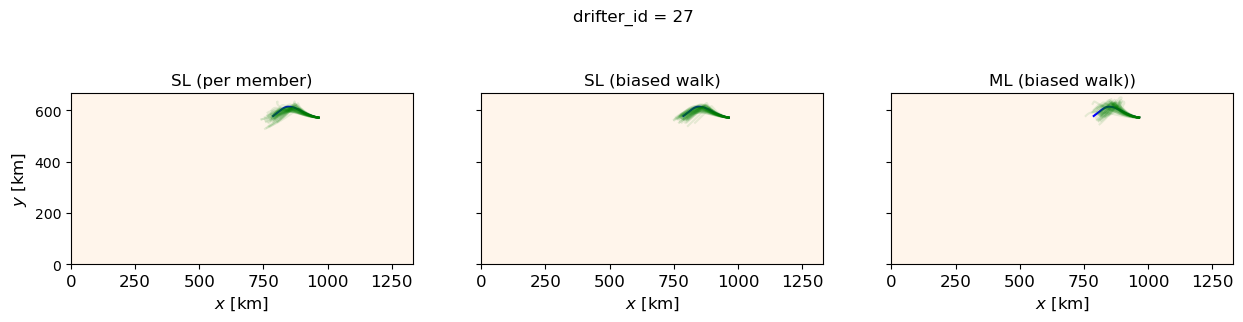

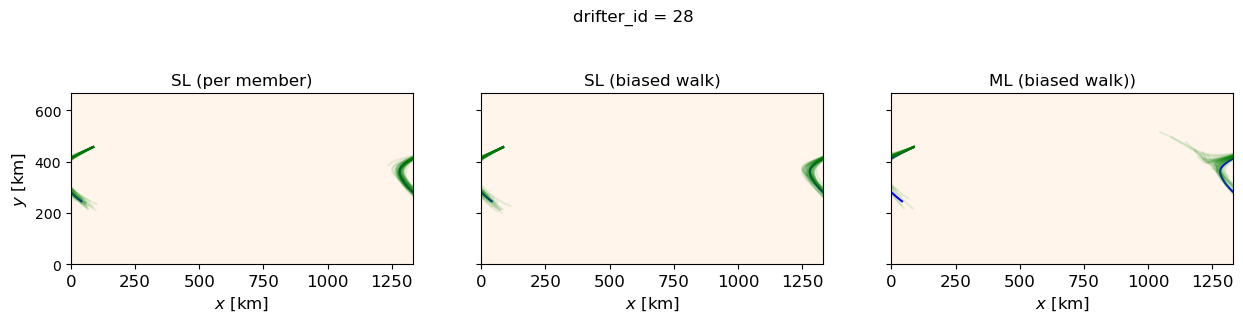

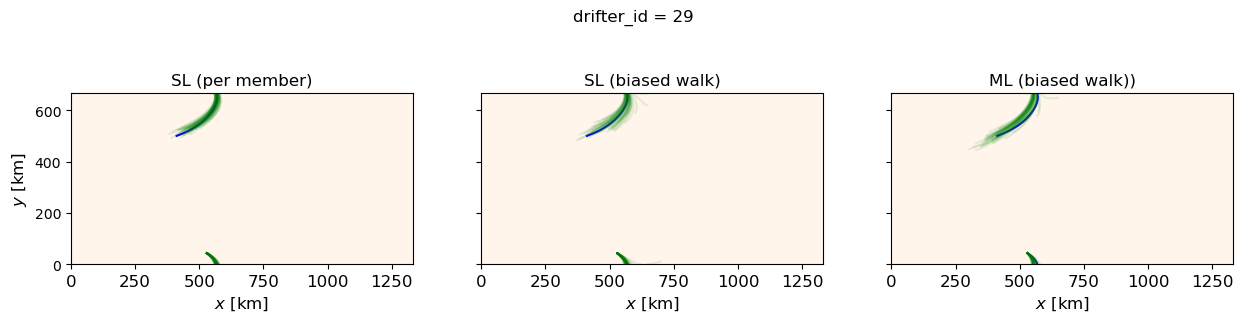

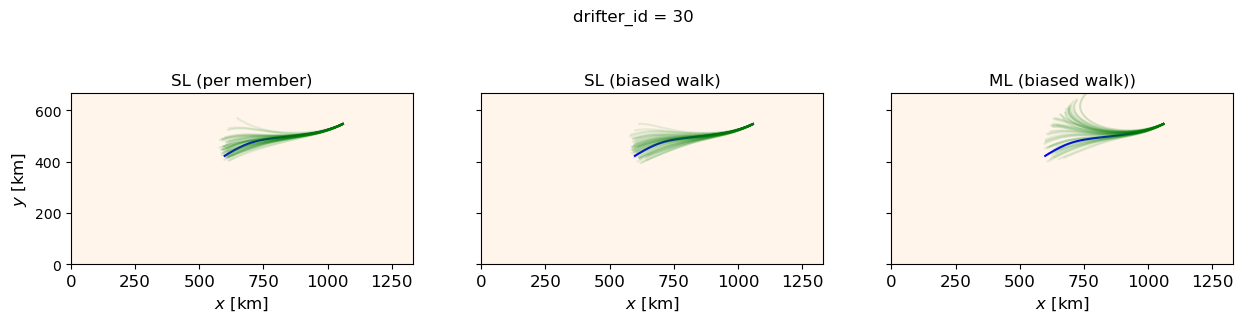

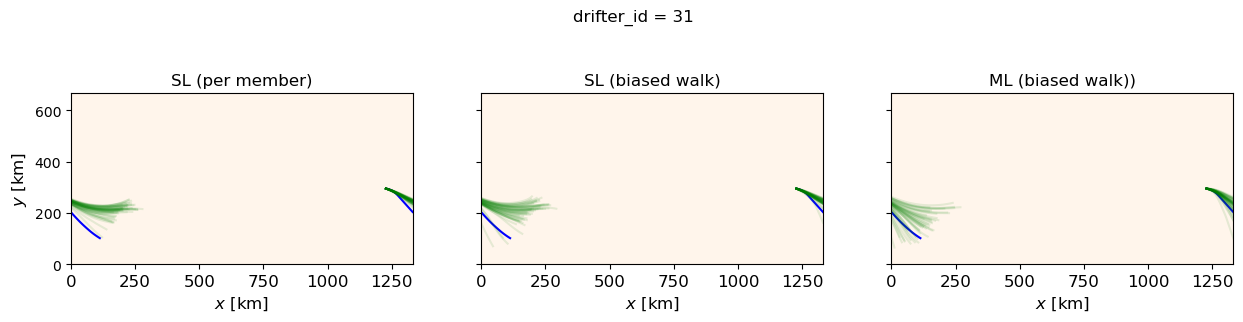

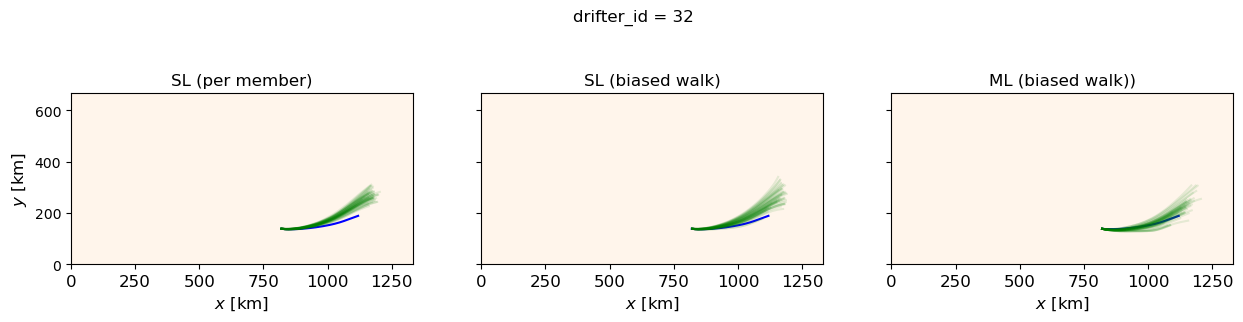

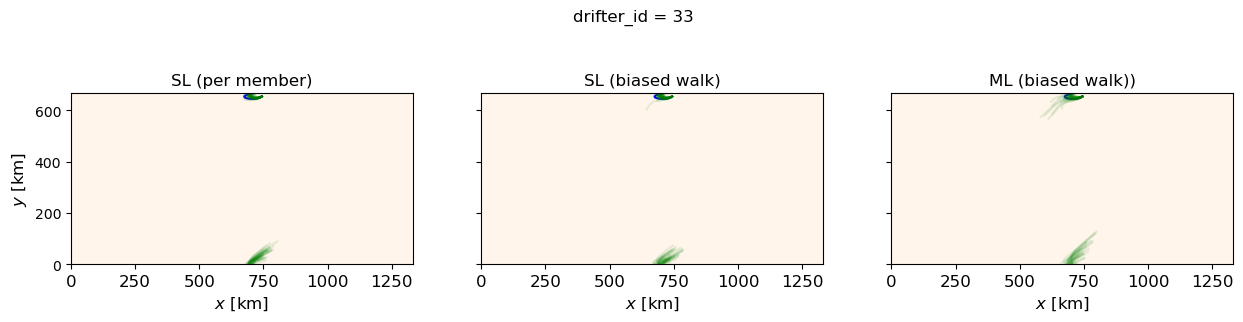

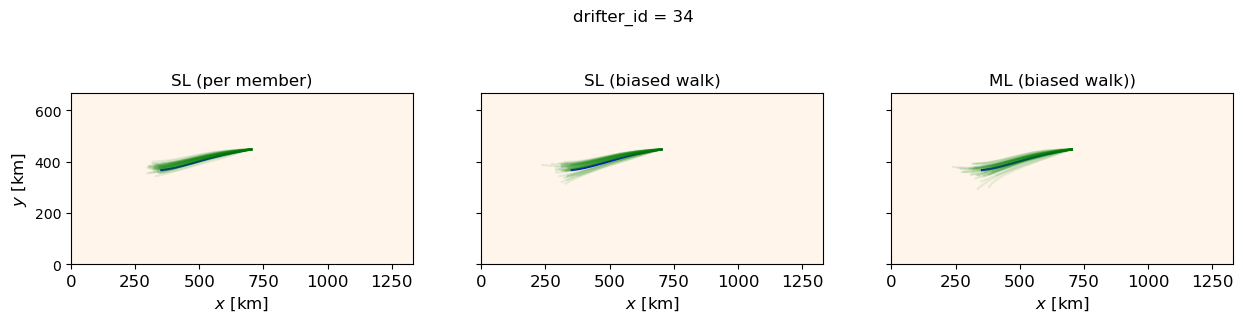

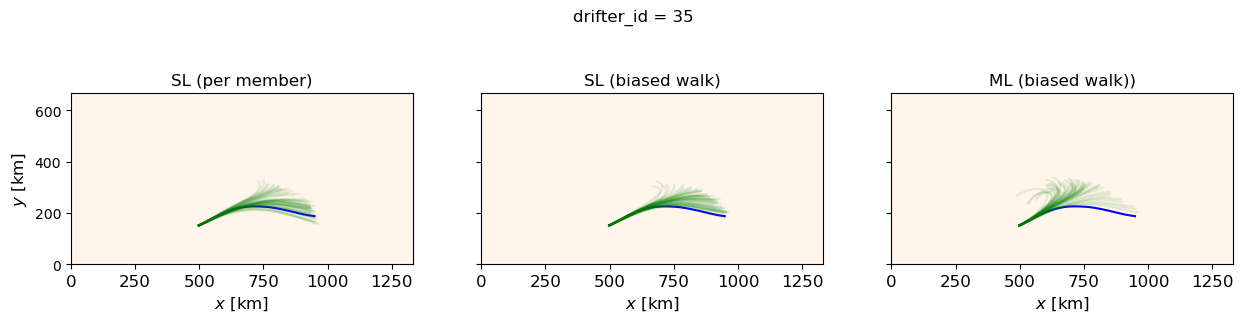

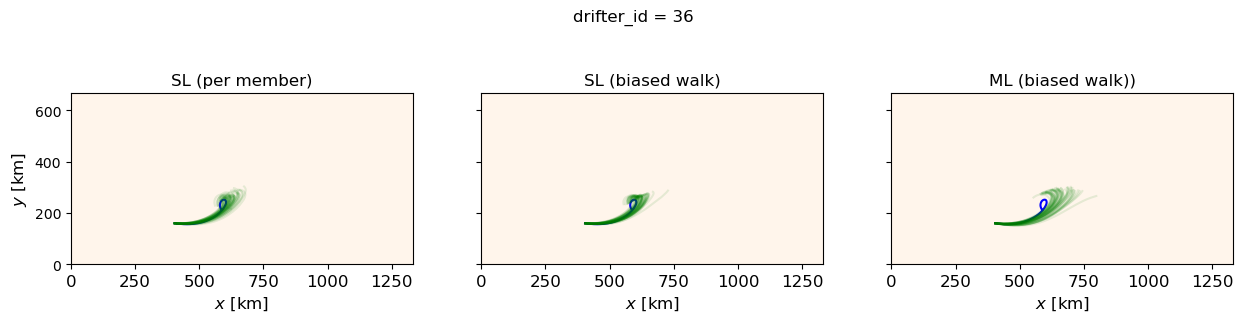

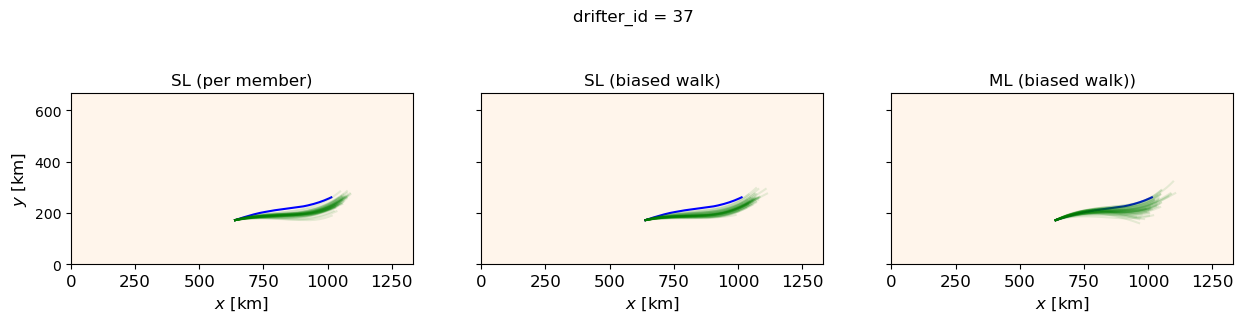

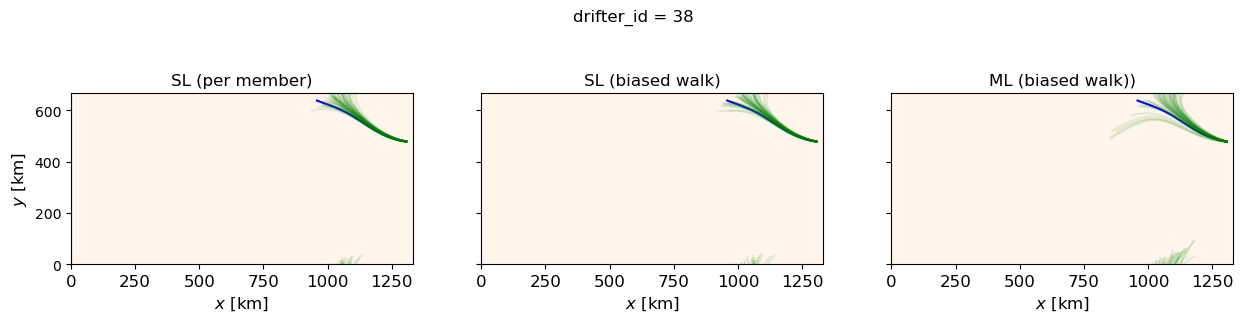

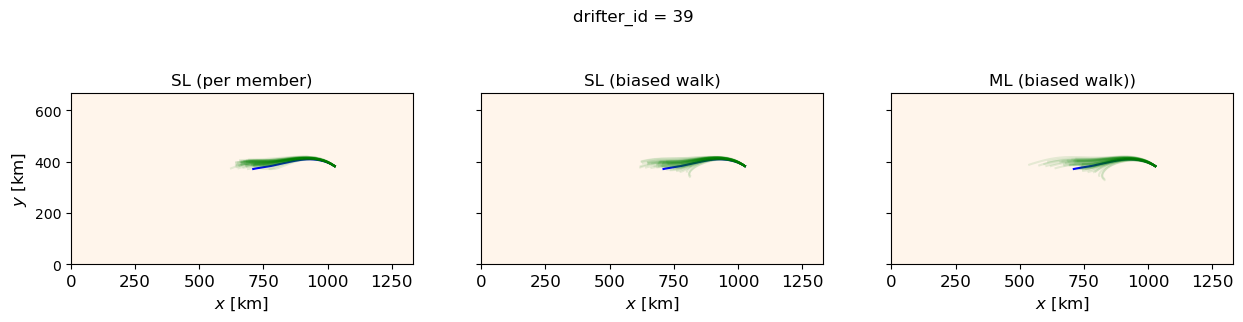

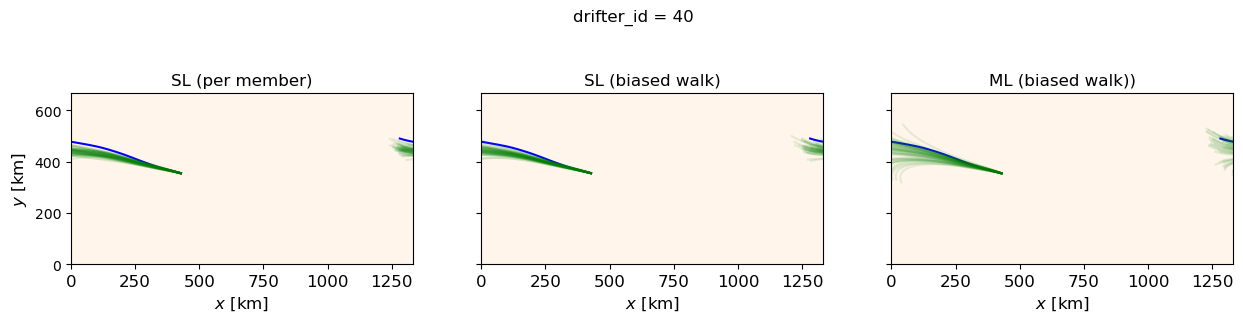

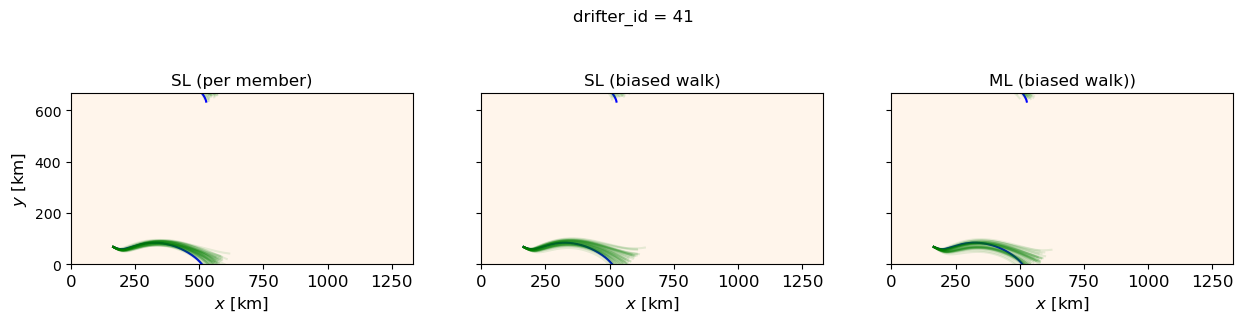

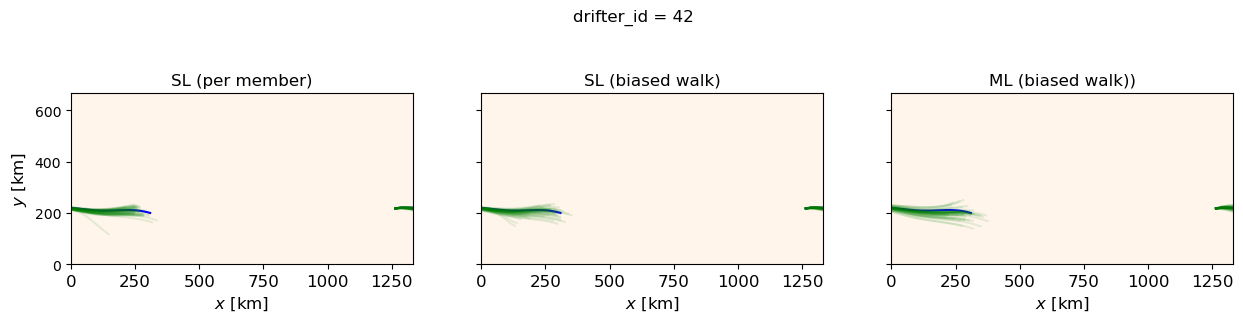

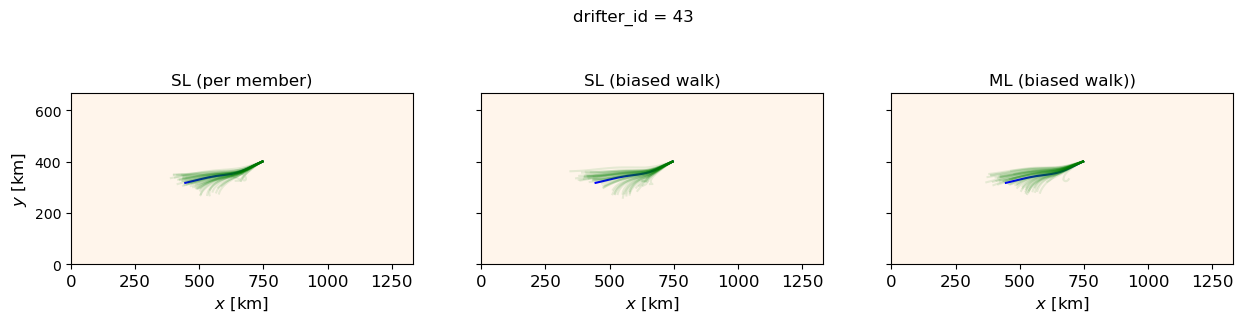

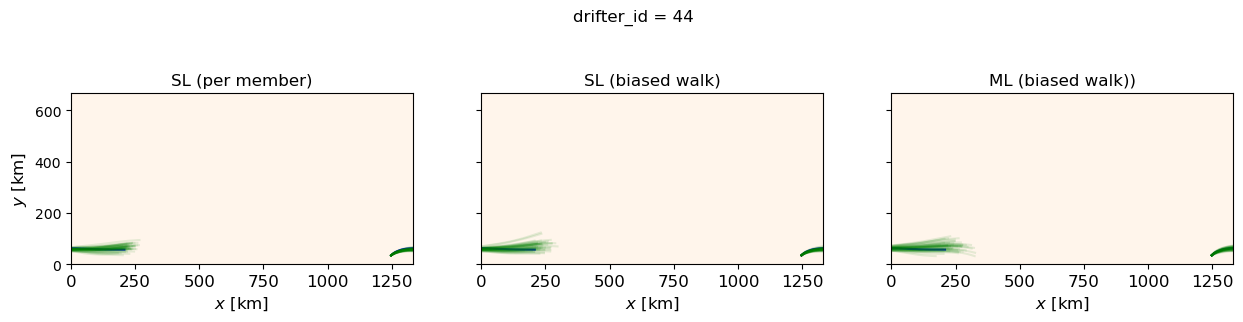

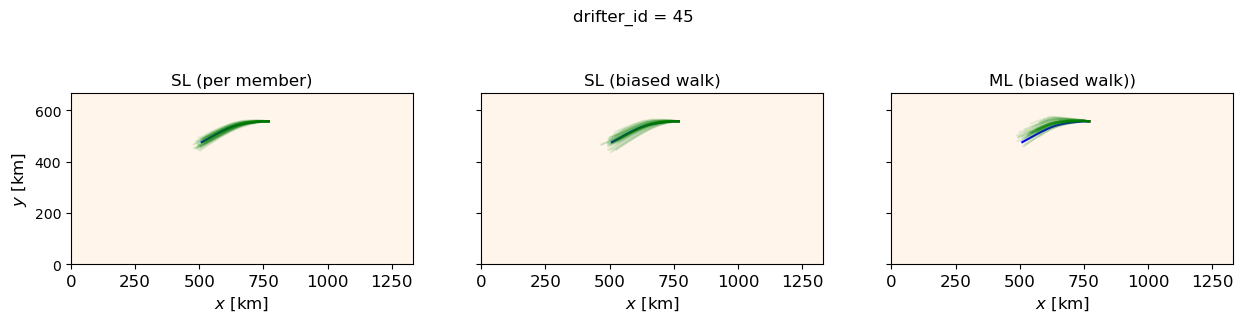

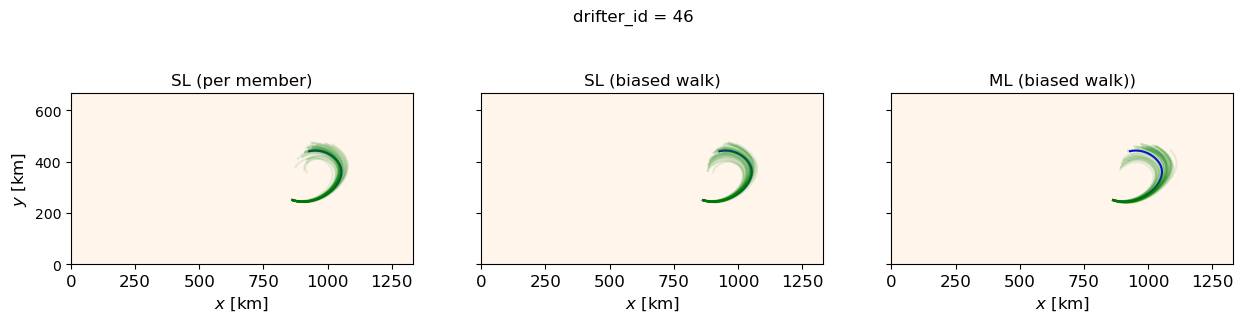

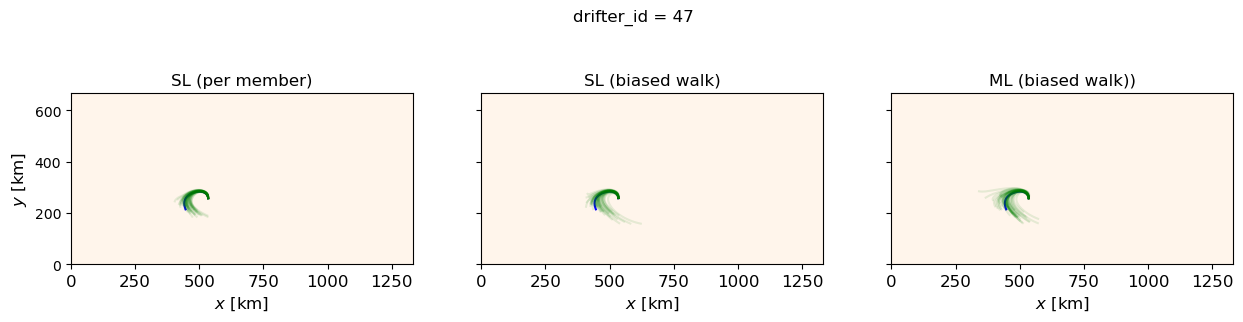

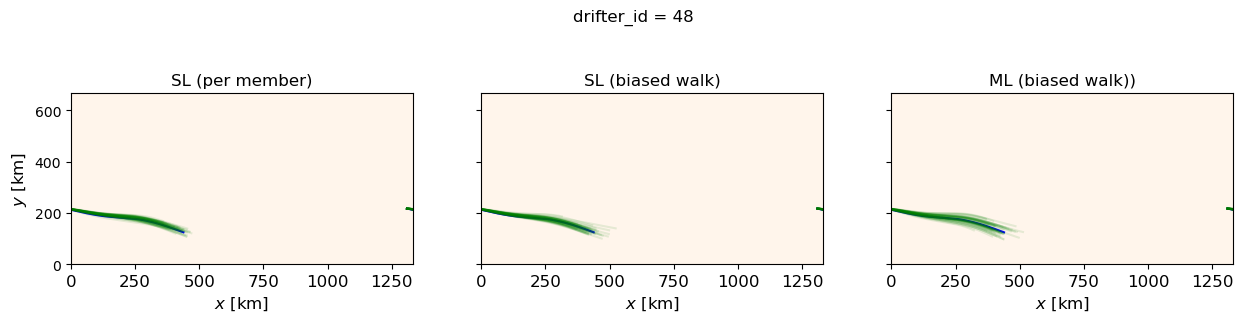

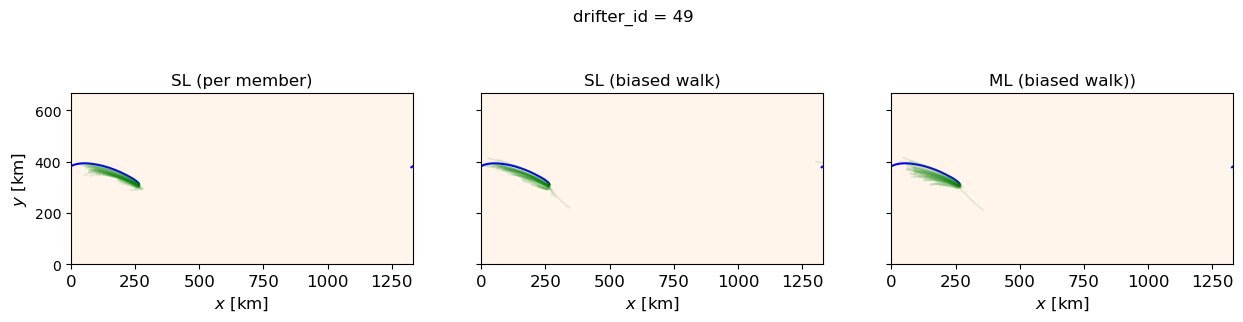

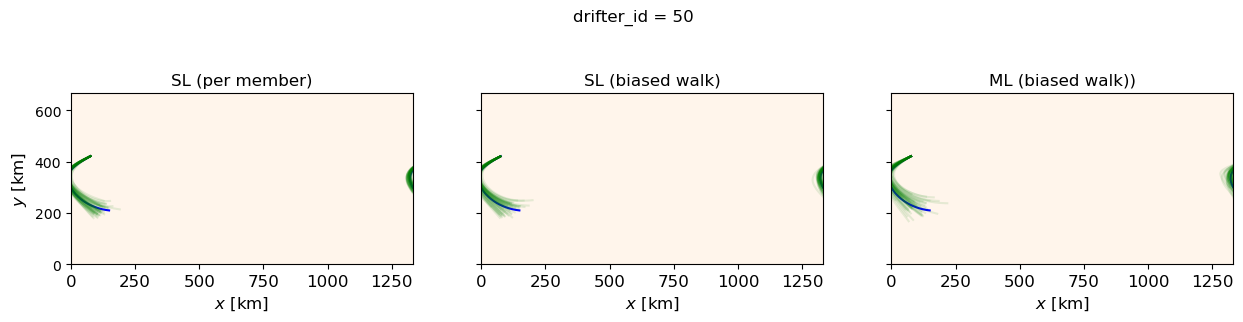

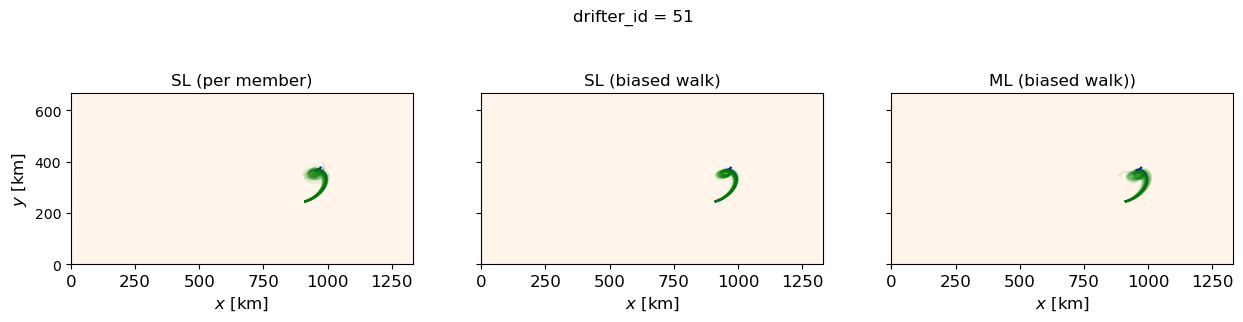

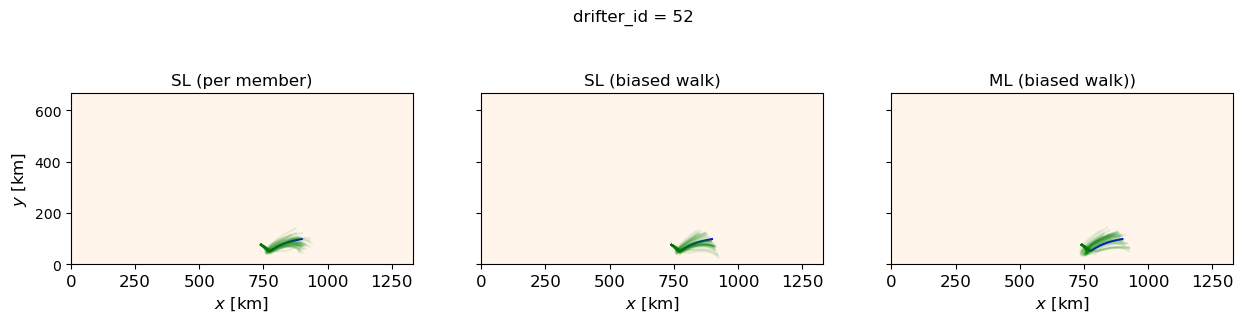

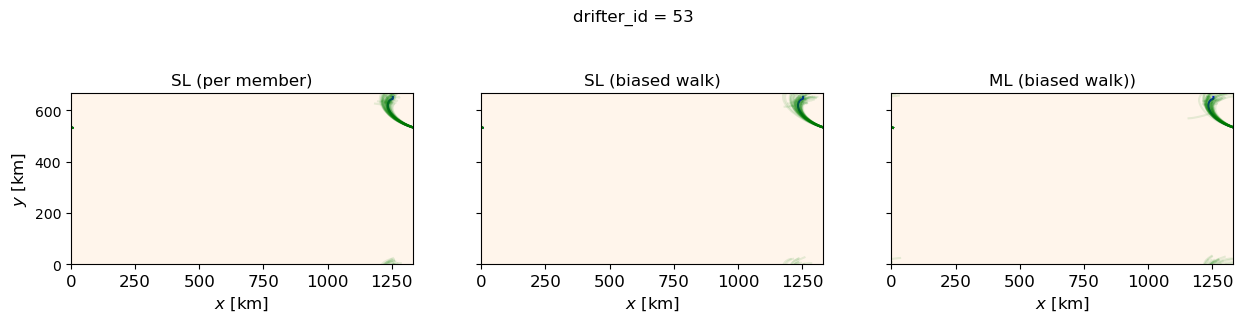

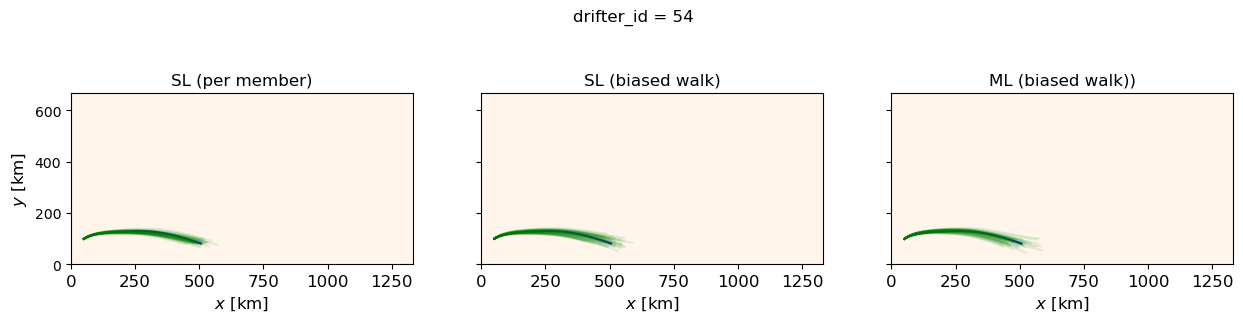

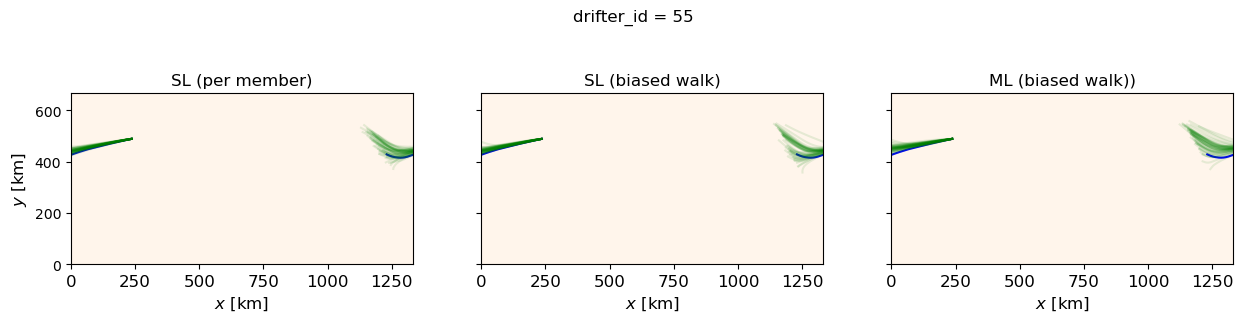

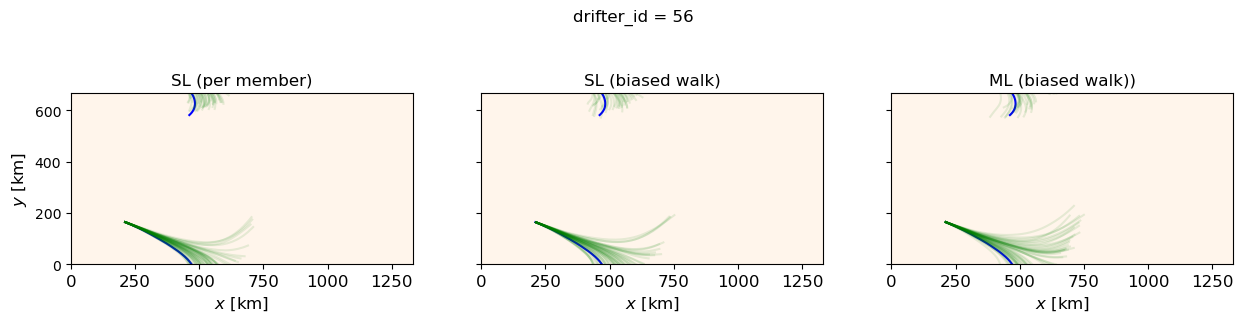

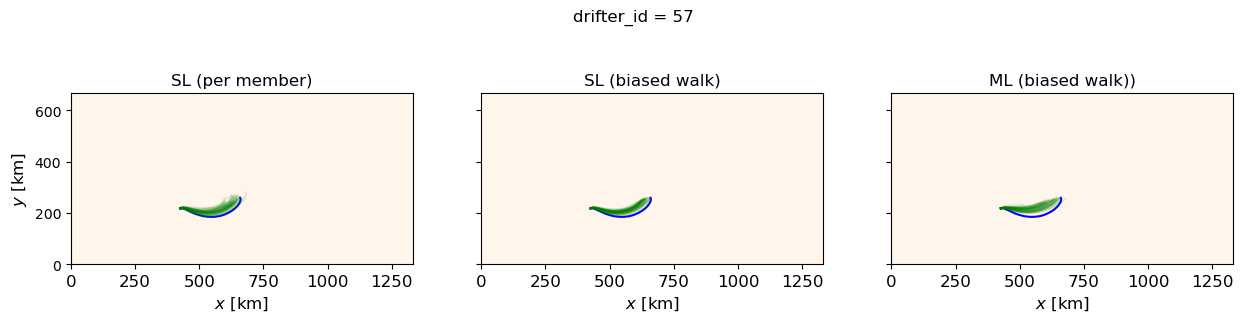

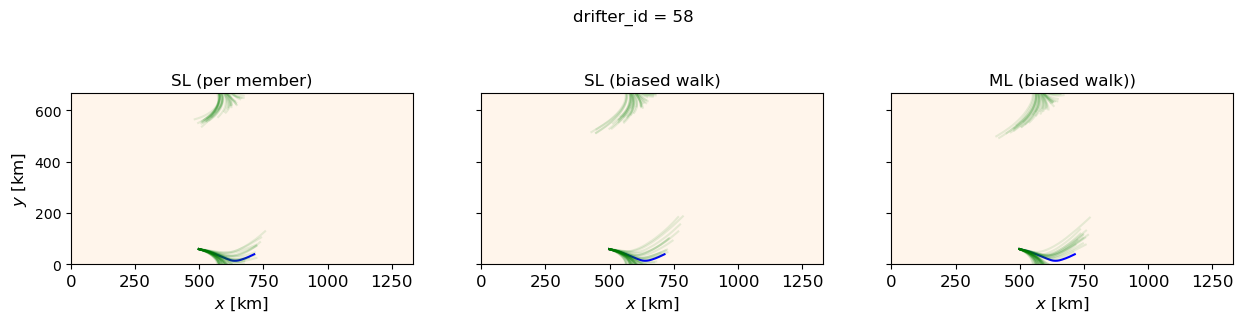

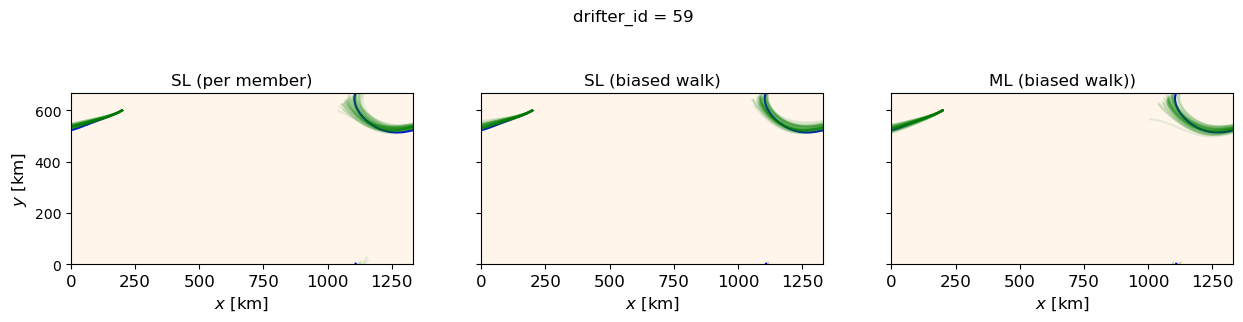

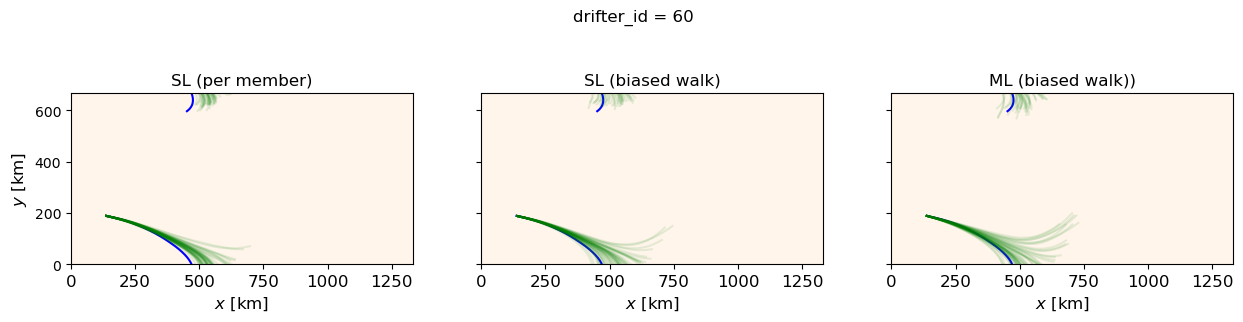

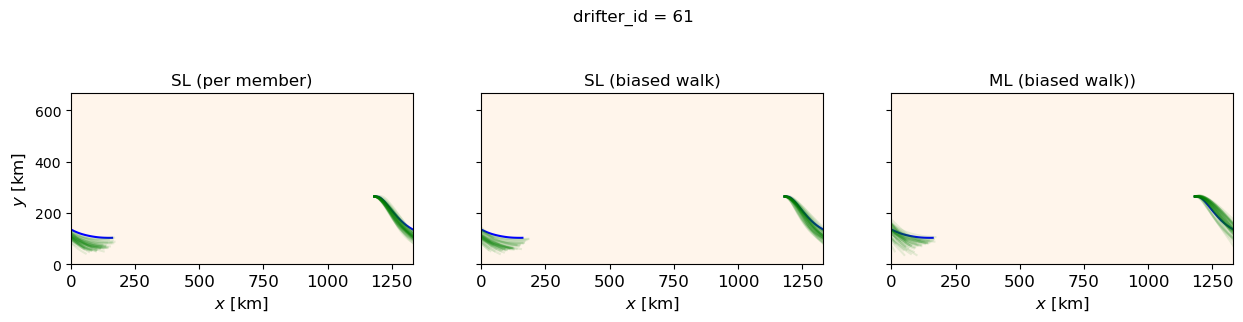

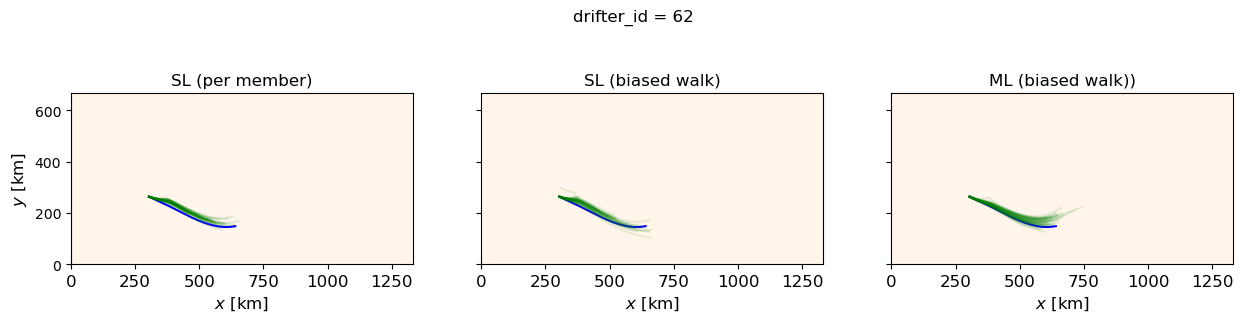

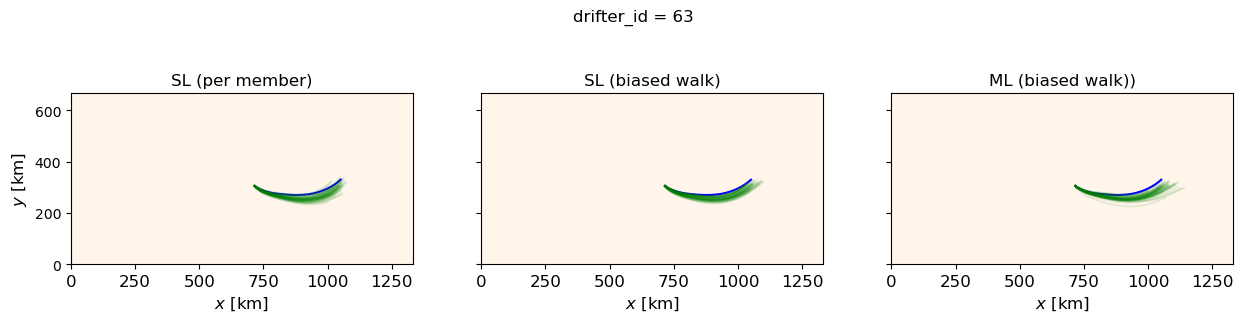

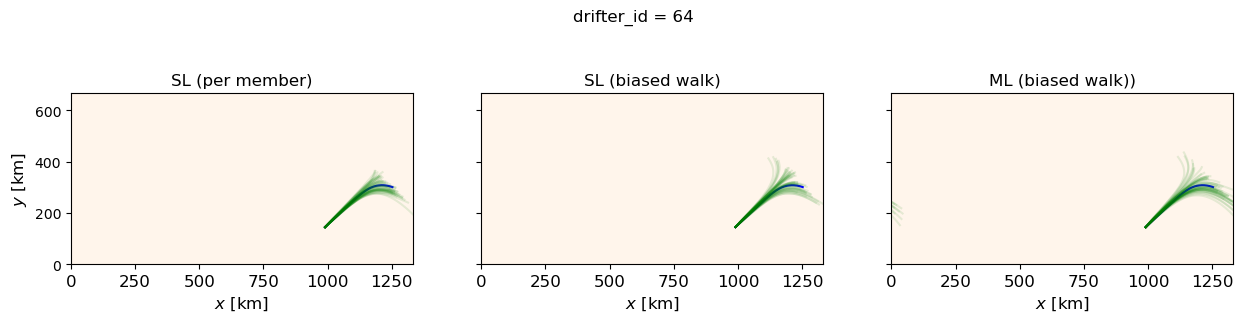

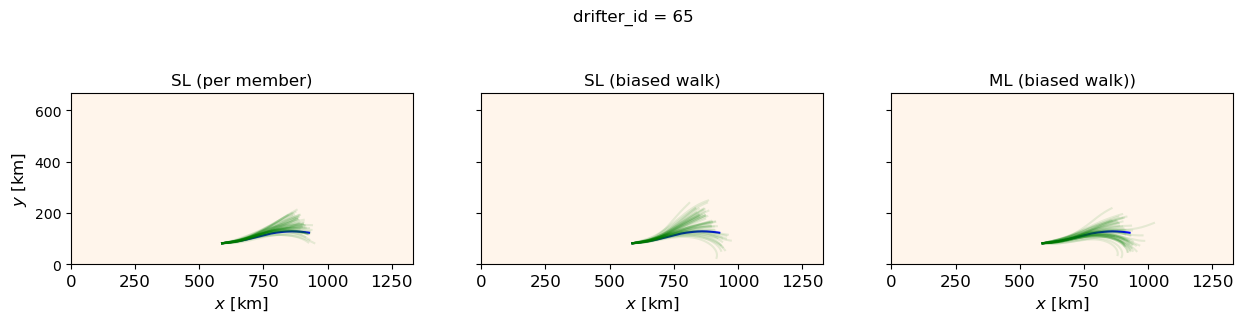

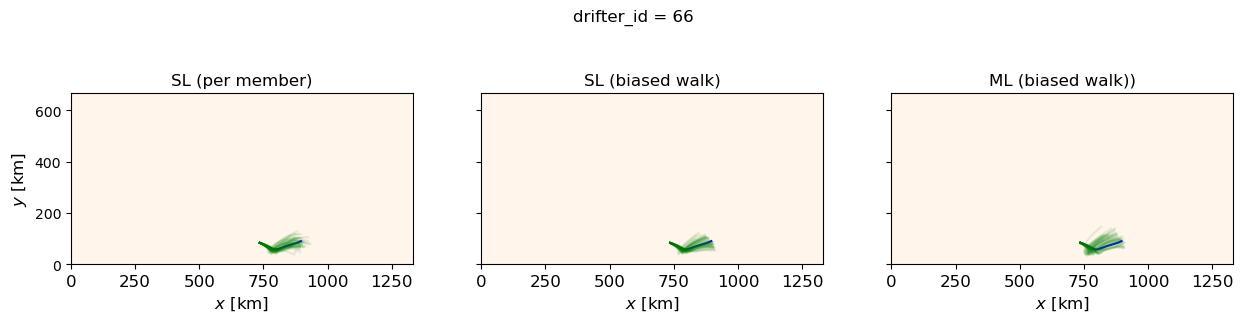

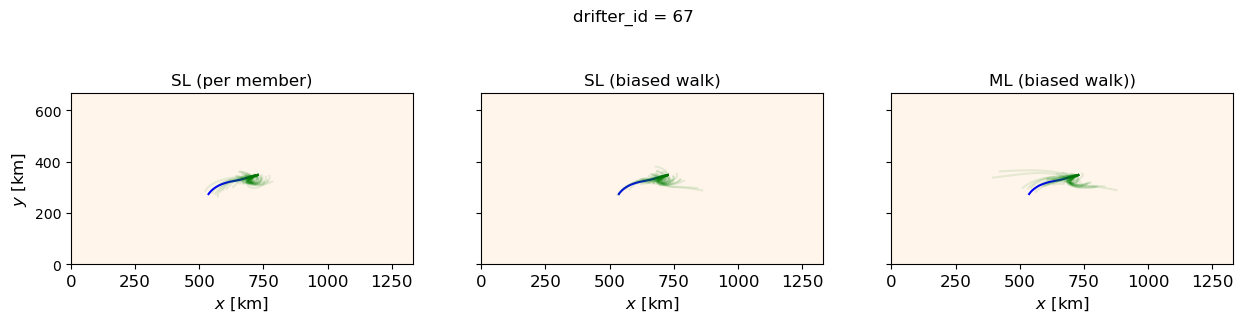

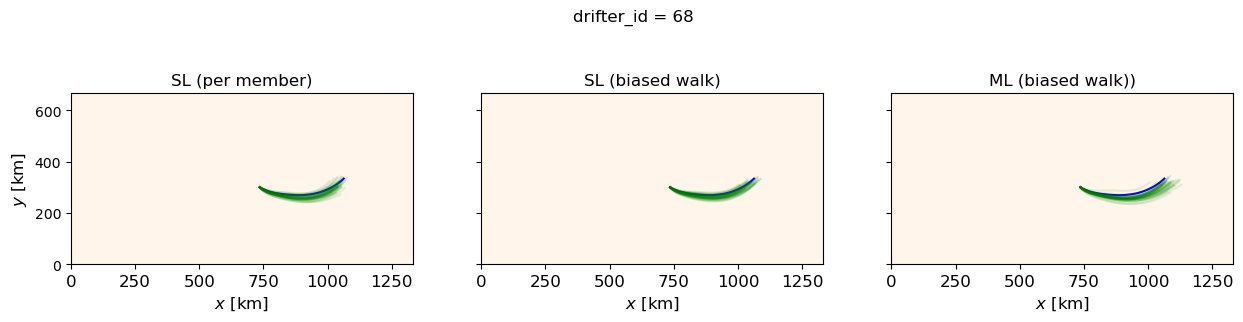

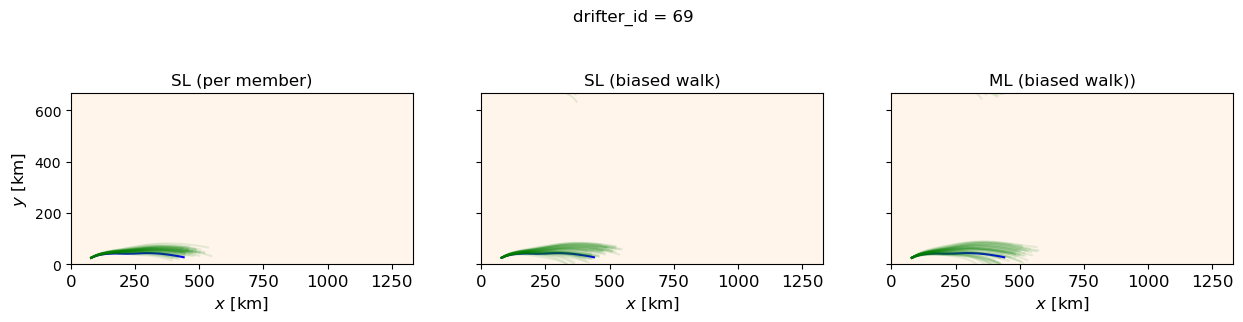

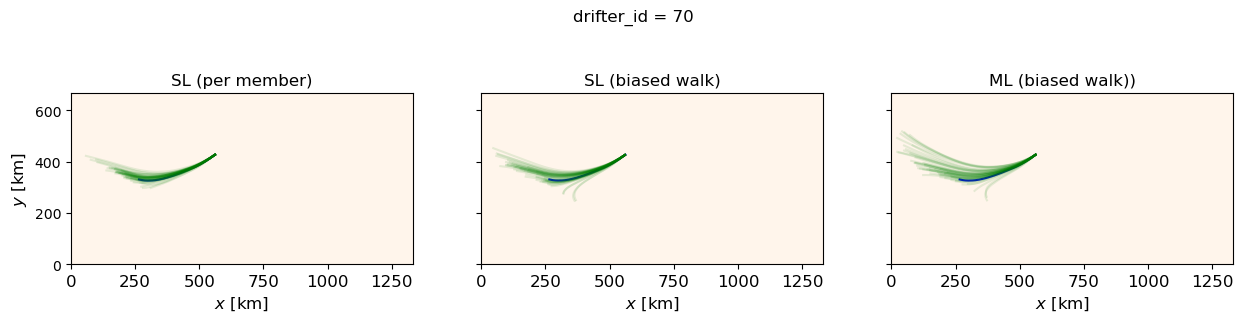

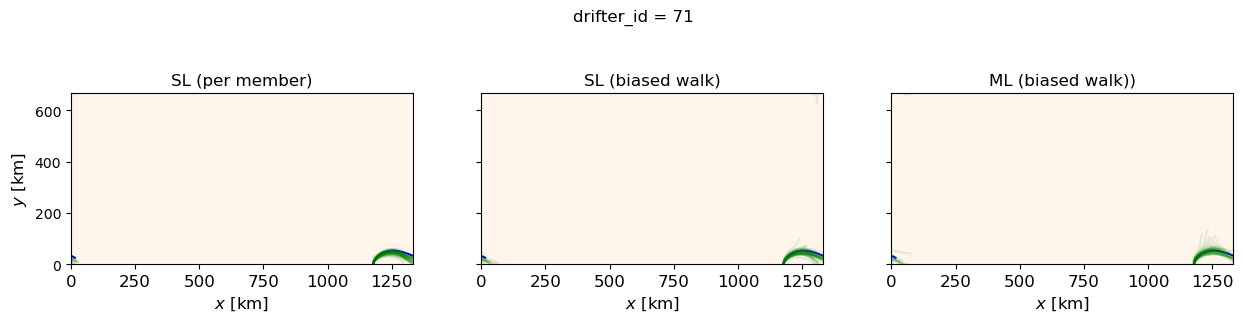

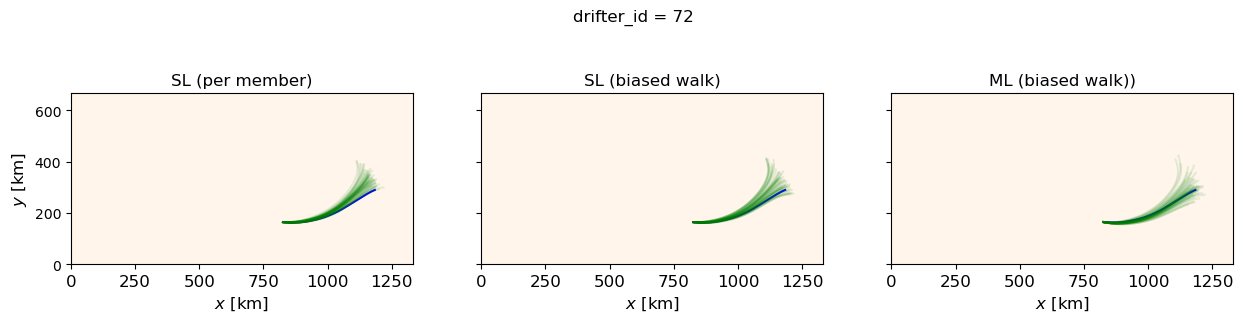

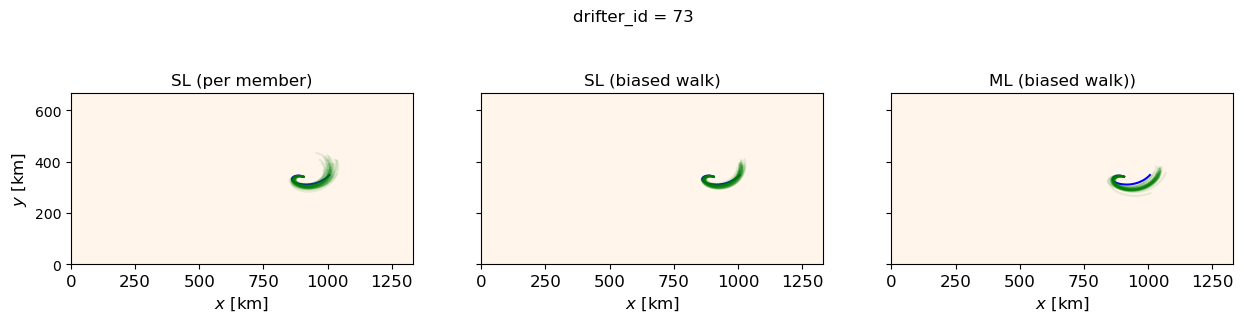

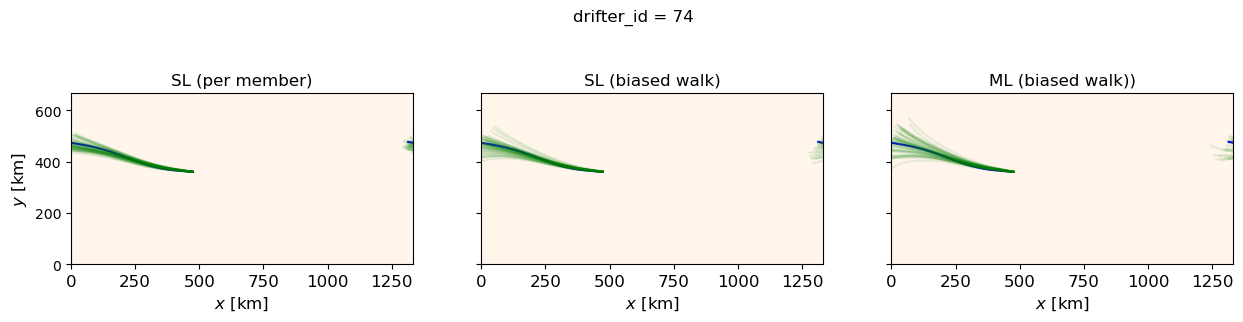

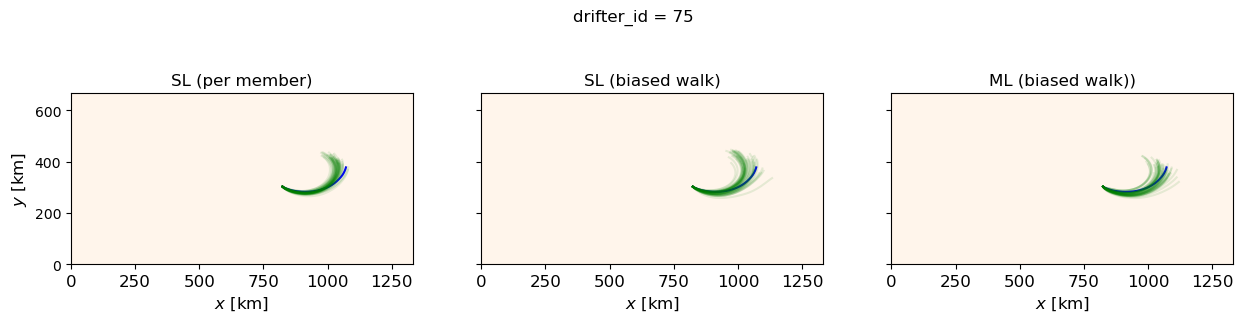

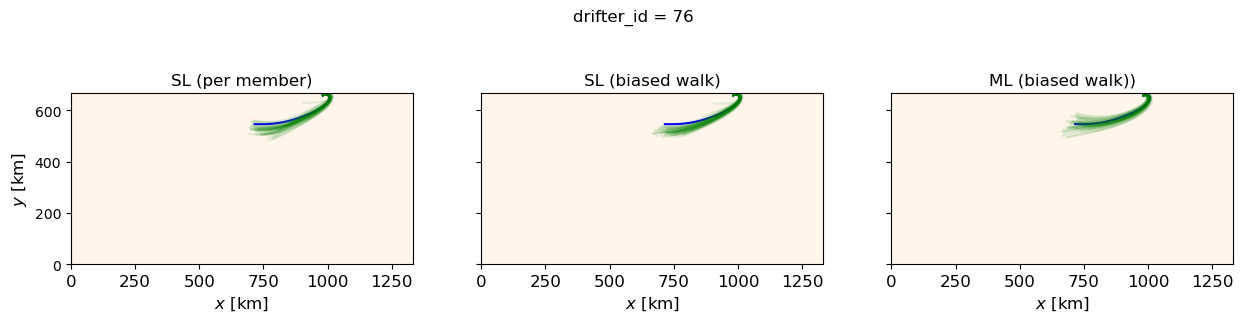

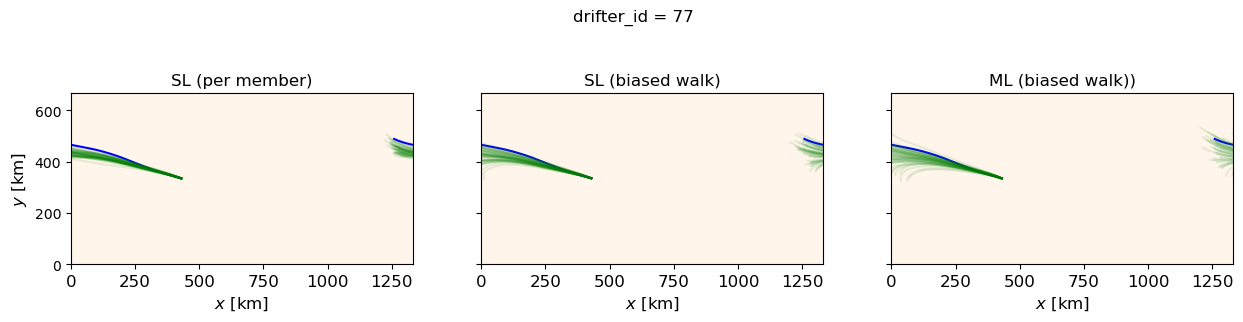

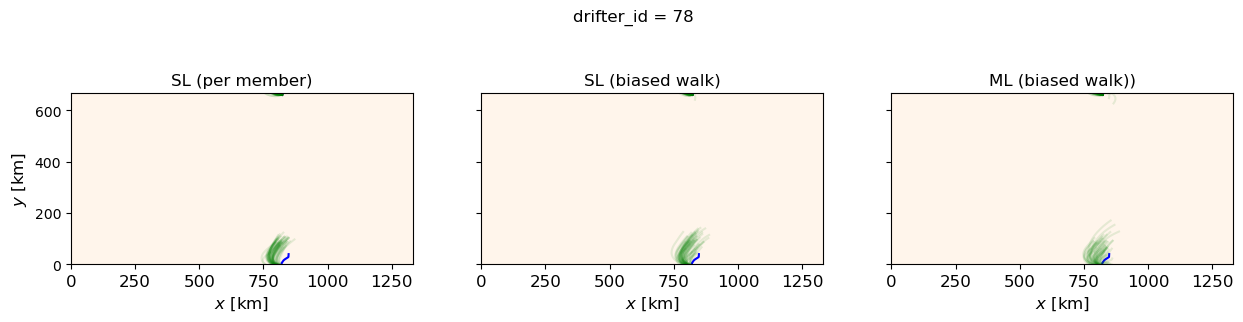

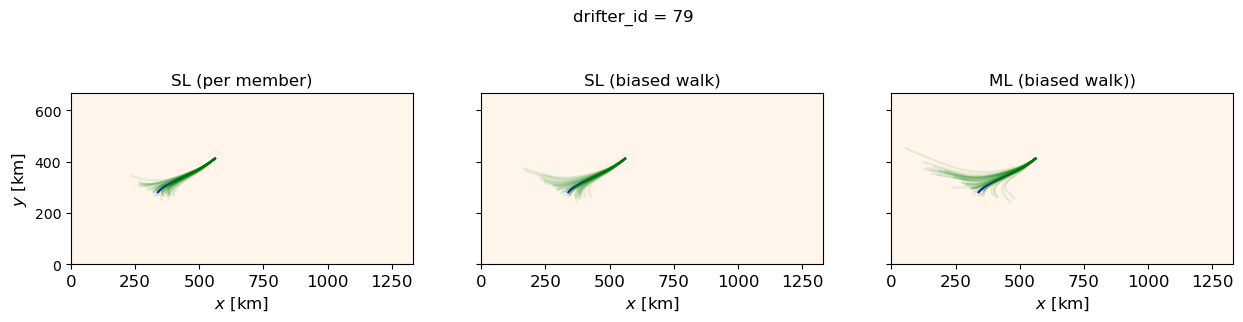

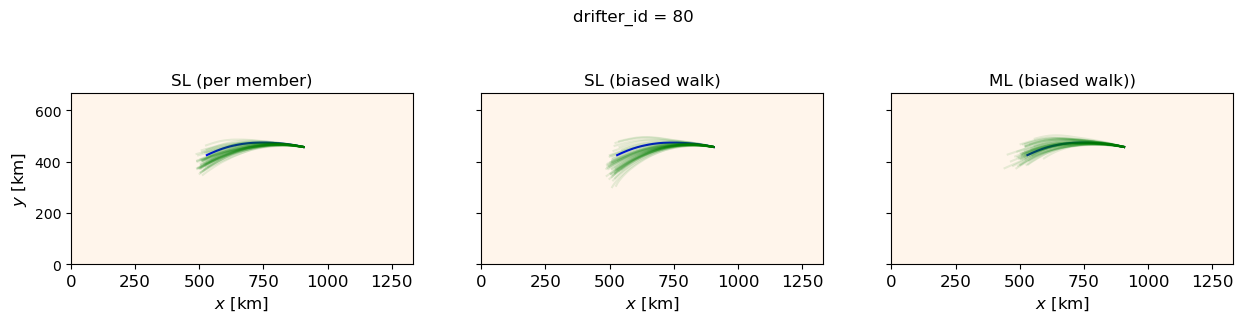

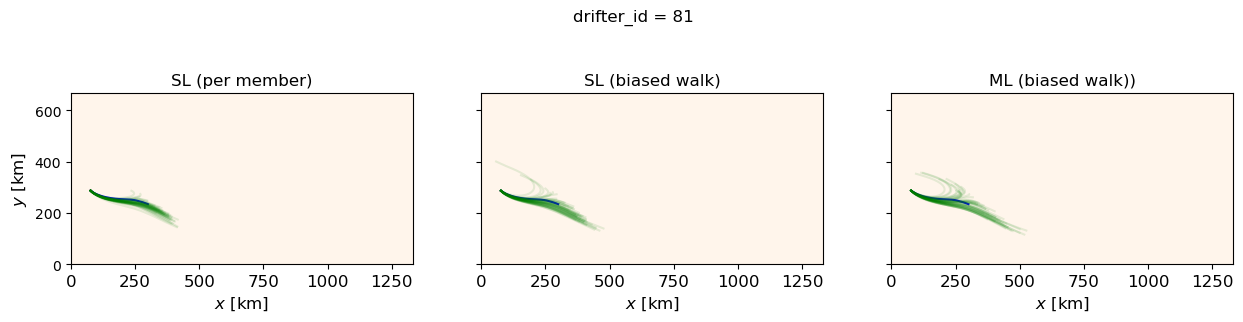

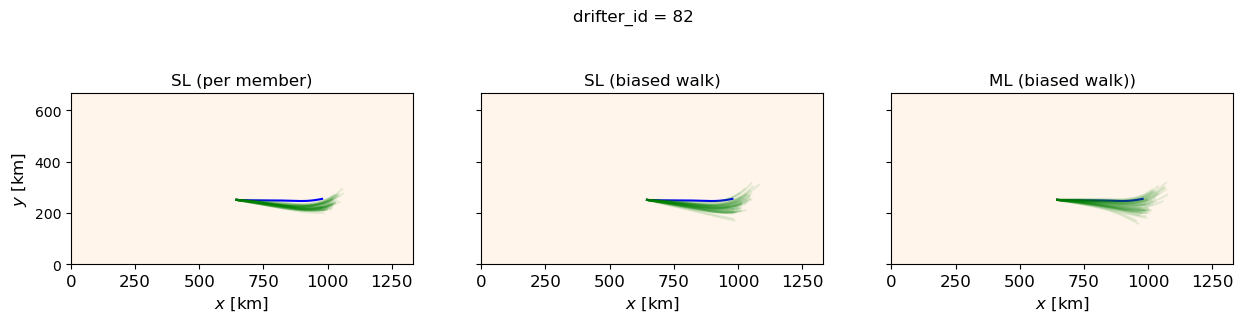

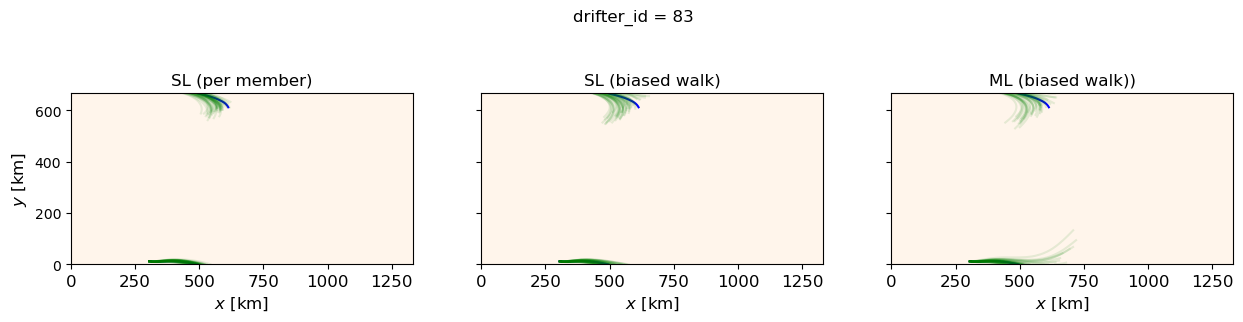

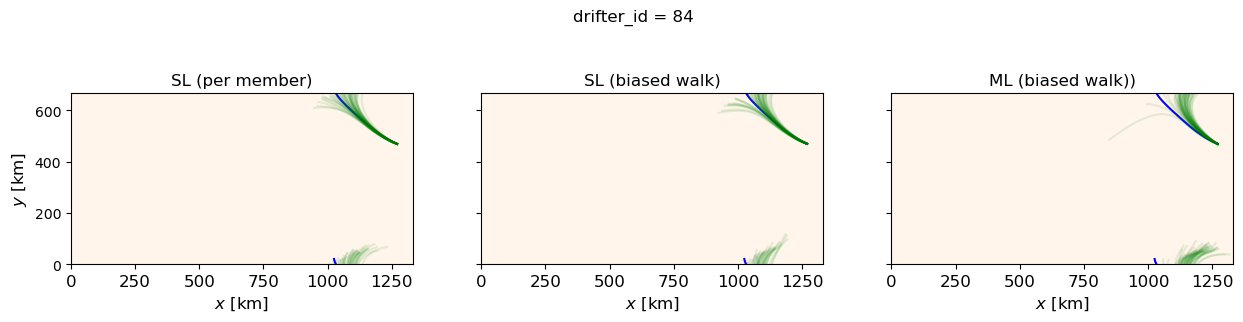

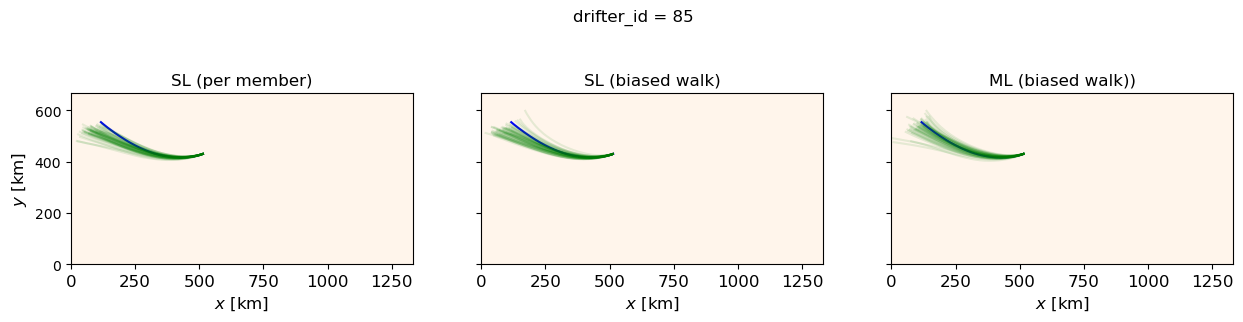

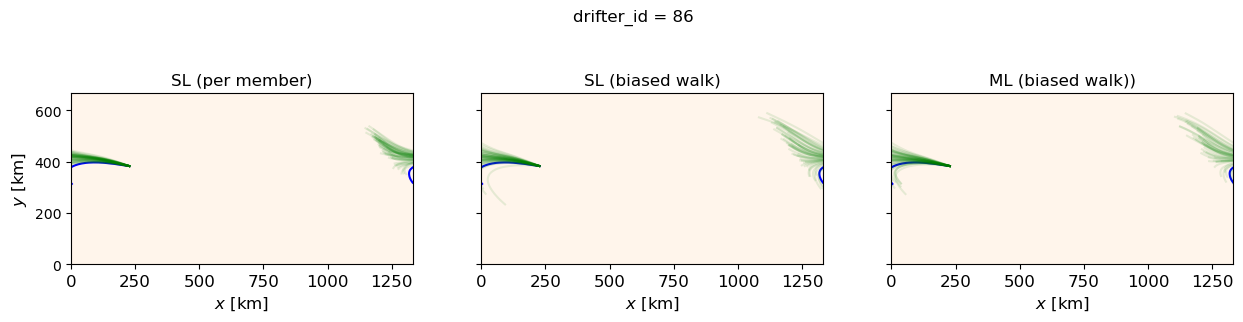

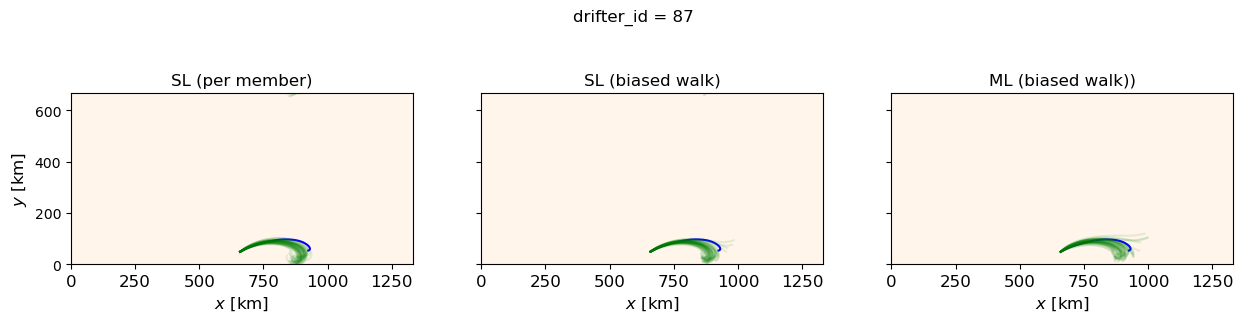

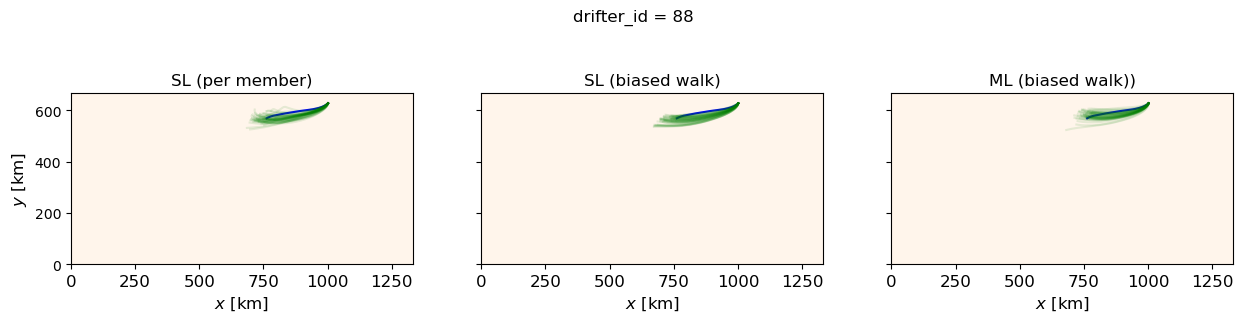

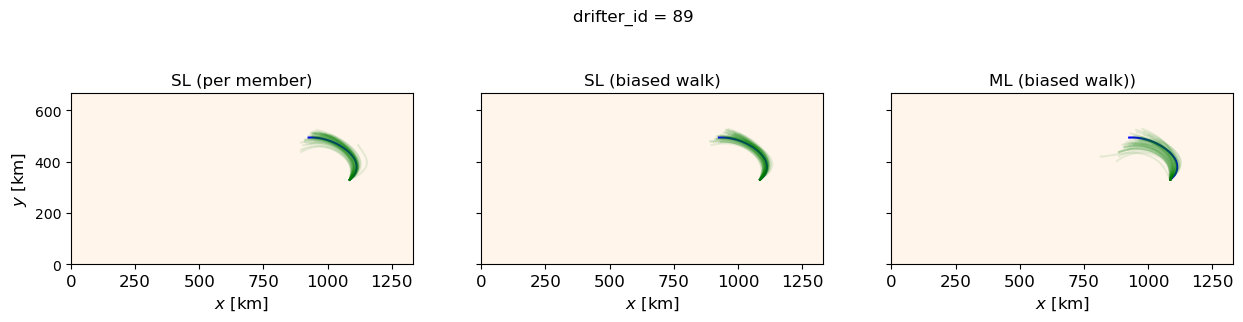

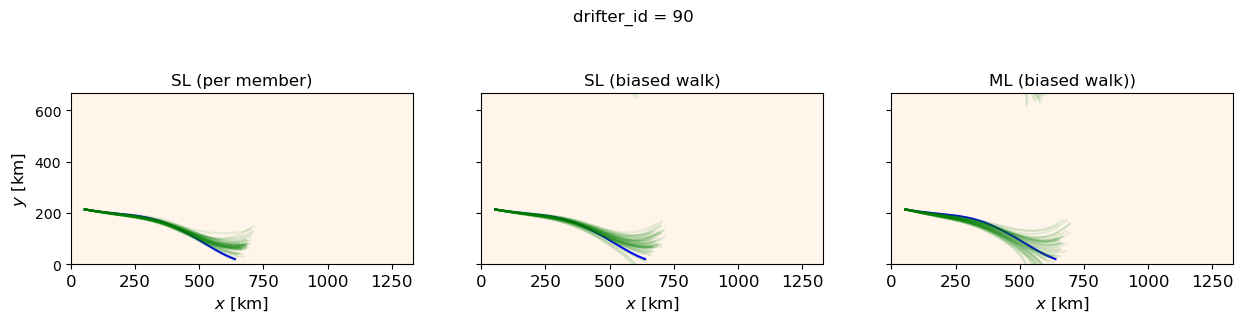

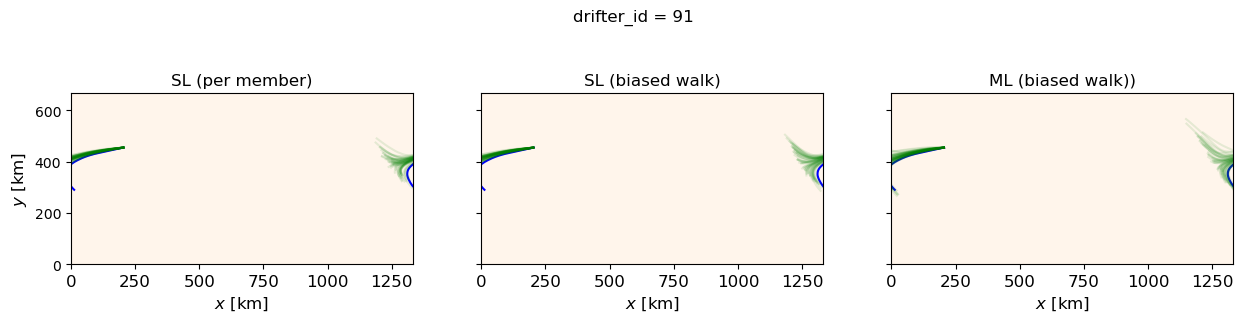

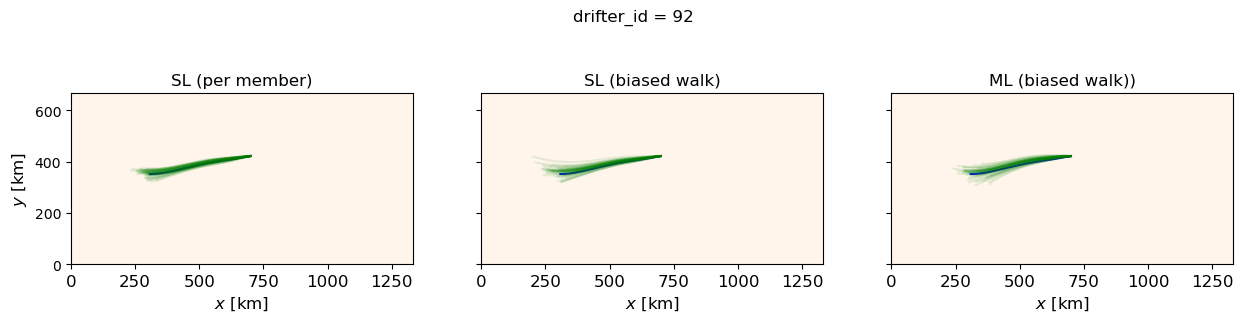

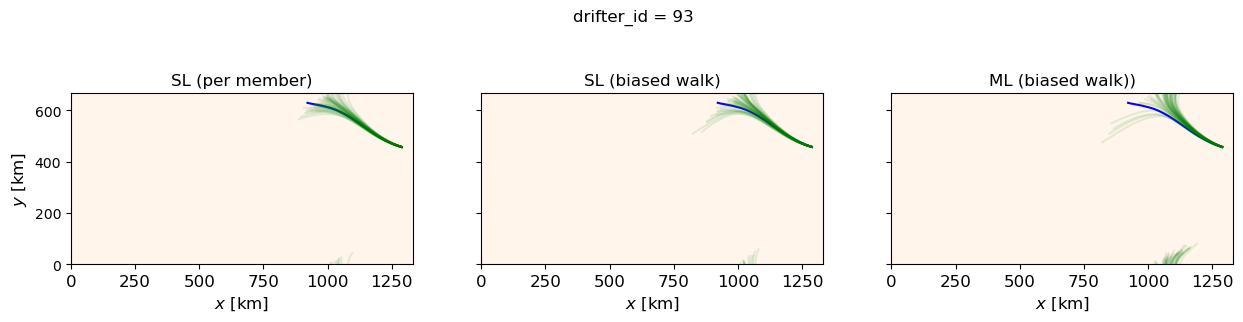

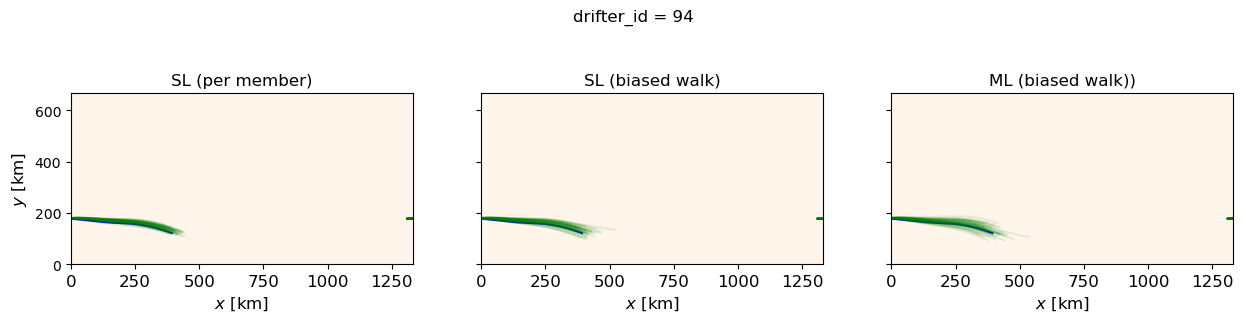

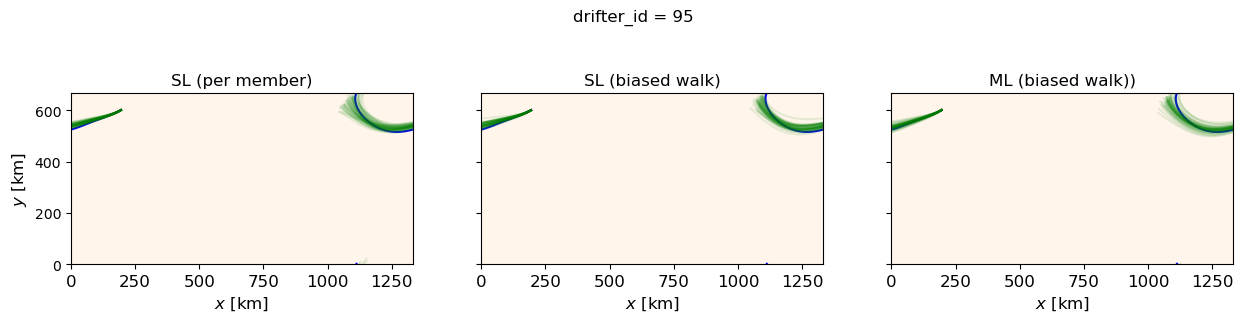

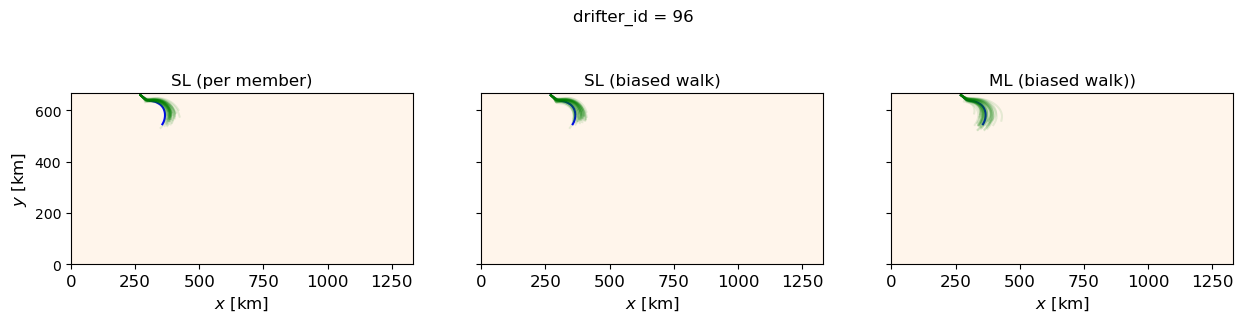

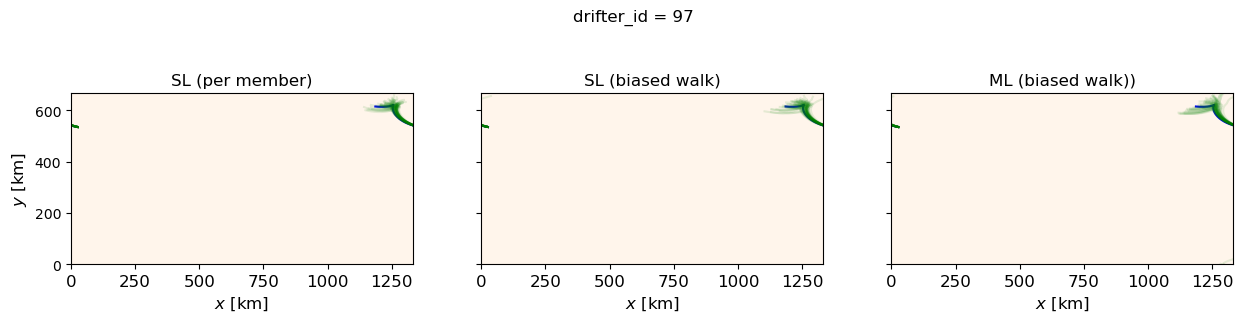

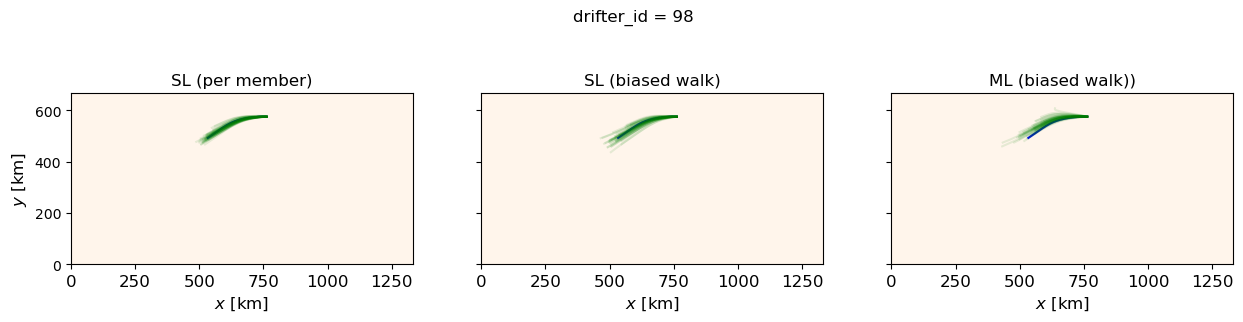

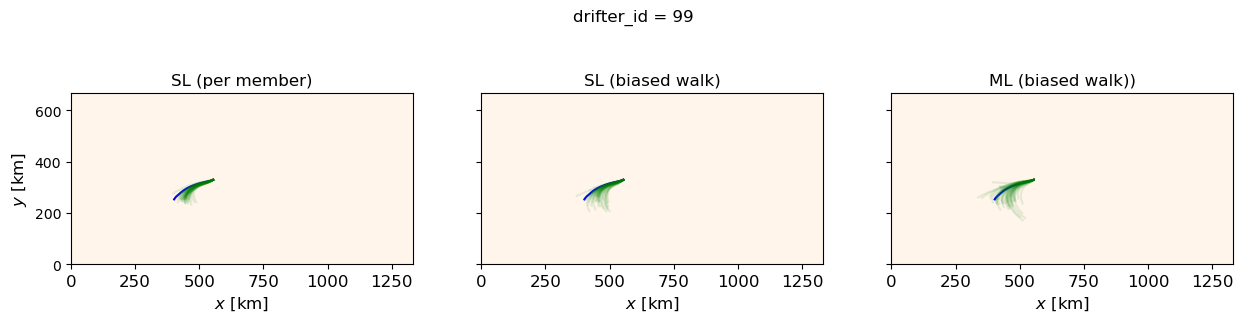

In [ ]:
for d in range(100):
    fig, axs = plt.subplots(1,3, figsize=(15,3.5))
    axs[0].set_title("SL (per member)")
    axs[1].set_title("SL (biased walk)")
    axs[2].set_title("ML (biased walk))")

    for i in range(len(axs)):
        DrifterPlotHelper.background_from_grid_parameters(doubleJetCase_args["nx"], doubleJetCase_args["ny"], doubleJetCase_args["dx"], doubleJetCase_args["dy"], ax=axs[i])
        DrifterPlotHelper.add_drifter_on_background(axs[i], true_trajectories, drifter_id=d)

    DrifterPlotHelper.add_ensemble_drifter_on_background(axs[0], slda_trajectories,       drifter_id=d, color='Green', alpha=0.1)
    DrifterPlotHelper.add_ensemble_drifter_on_background(axs[1], slda_trajectories2[:50], drifter_id=d, color='Green', alpha=0.1)
    DrifterPlotHelper.add_ensemble_drifter_on_background(axs[2], mlda_trajectories[:50] , drifter_id=d, color='Green', alpha=0.1)


    axs[0].set_ylabel(r"$y$ [km]", fontsize=12)
    for i in range(len(axs)):
        axs[i].tick_params(axis='x', labelsize=12)
        axs[i].set_xlabel(r"$x$ [km]", fontsize=12)
        if i>0:
            axs[i].set_yticklabels([])

    fig.suptitle("drifter_id = " +str(d))

/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


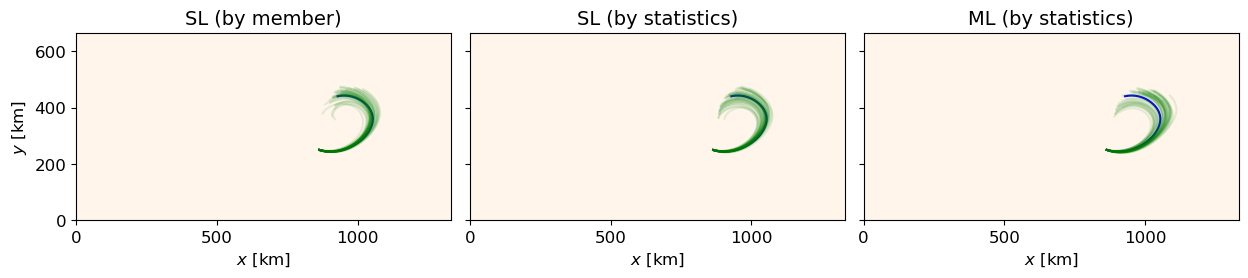

In [24]:
d =46 

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 4.5))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1], wspace=0.05)

for i in range(3):
    ax = plt.subplot(gs[i])
    DrifterPlotHelper.background_from_grid_parameters(doubleJetCase_args["nx"], doubleJetCase_args["ny"], doubleJetCase_args["dx"], doubleJetCase_args["dy"], ax=ax)
    DrifterPlotHelper.add_drifter_on_background(ax, true_trajectories, drifter_id=d)

    if i == 0:
        DrifterPlotHelper.add_ensemble_drifter_on_background(ax, slda_trajectories,       drifter_id=d, color='Green', alpha=0.1)
        ax.set_title("SL (by member)", fontsize=14)
    if i == 1:
        DrifterPlotHelper.add_ensemble_drifter_on_background(ax, slda_trajectories2[:50], drifter_id=d, color='Green', alpha=0.1)
        ax.set_title("SL (by statistics)", fontsize=14)
    if i == 2:
        DrifterPlotHelper.add_ensemble_drifter_on_background(ax, mlda_trajectories[:50] , drifter_id=d, color='Green', alpha=0.1)
        ax.set_title("ML (by statistics)", fontsize=14)

    ax.tick_params(axis='x', labelsize=12)
    ax.set_xlabel(r"$x$ [km]", fontsize=12)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_xticks([0, 500, 1000])
    if i>0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel(r"$y$ [km]", fontsize=12)

plt.tight_layout()

plt.savefig("DoubleJet-DA-PostProcessing-Drifters4paper_"+str(d)+".pdf", bbox_inches="tight", dpi=300)


/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[46, 23, 15]


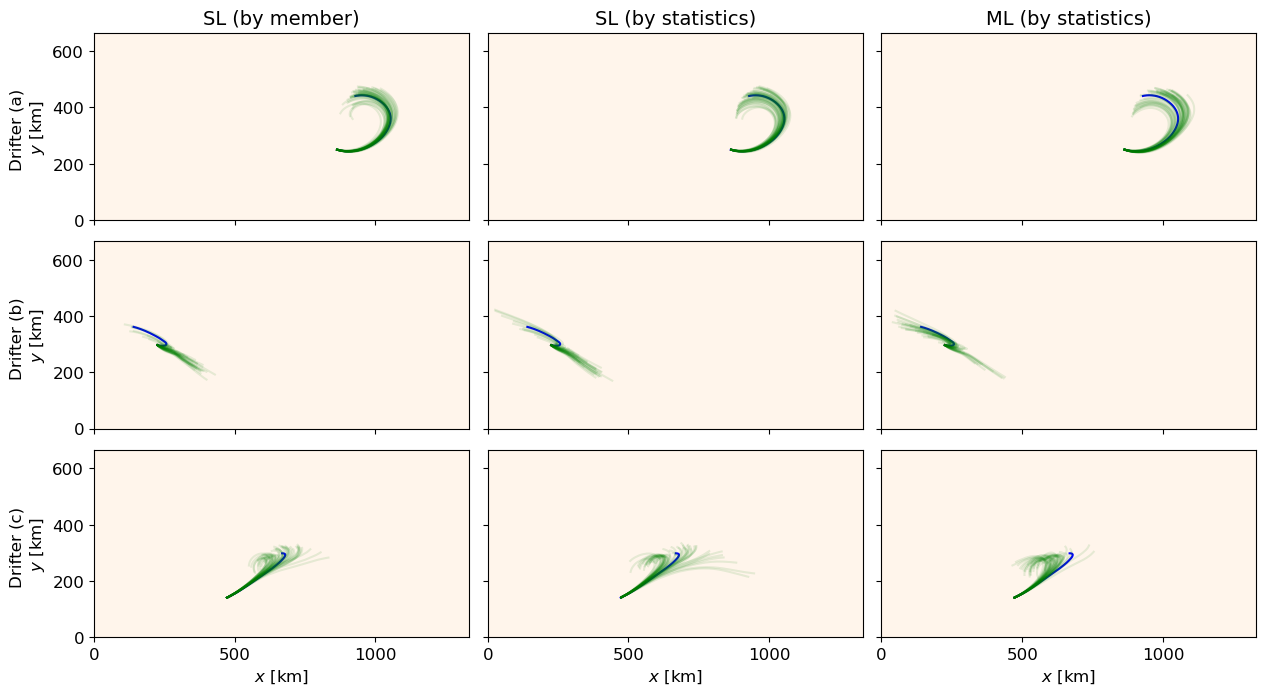

In [41]:
ds = [46, 23, 15]

import matplotlib.gridspec as gridspec
import string

fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(3, 3, width_ratios=[1, 1, 1], wspace=0.05, hspace=0.05)


for d_idx in range(len(ds)):
    for i in range(3):
        ax = plt.subplot(gs[d_idx,i])
        DrifterPlotHelper.background_from_grid_parameters(doubleJetCase_args["nx"], doubleJetCase_args["ny"], doubleJetCase_args["dx"], doubleJetCase_args["dy"], ax=ax)
        DrifterPlotHelper.add_drifter_on_background(ax, true_trajectories, drifter_id=ds[d_idx])

        if i == 0:
            DrifterPlotHelper.add_ensemble_drifter_on_background(ax, slda_trajectories,       drifter_id=ds[d_idx], color='Green', alpha=0.1)
            if d_idx == 0:
                ax.set_title("SL (by member)", fontsize=14)
        if i == 1:
            DrifterPlotHelper.add_ensemble_drifter_on_background(ax, slda_trajectories2[:50], drifter_id=ds[d_idx], color='Green', alpha=0.1)
            if d_idx == 0:
                ax.set_title("SL (by statistics)", fontsize=14)
        if i == 2:
            DrifterPlotHelper.add_ensemble_drifter_on_background(ax, mlda_trajectories[:50] , drifter_id=ds[d_idx], color='Green', alpha=0.1)
            if d_idx == 0:
                ax.set_title("ML (by statistics)", fontsize=14)

        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)

        ax.set_xticks([0, 500, 1000])
        if d_idx == len(ds)-1:
            ax.set_xlabel(r"$x$ [km]", fontsize=12)
        else:
            ax.set_xticklabels([])
        
        if i>0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(r"Drifter ("+string.ascii_lowercase[d_idx]+") " "\n" r"$y$ [km]", fontsize=12)

plt.tight_layout()

plt.savefig("DoubleJet-DA-PostProcessing-Drifters4paper.pdf", bbox_inches="tight", dpi=300)

print(ds)